In [3]:
import praw
import requests
from datetime import datetime, timedelta
import pandas as pd
from prawcore import Forbidden, NotFound
from tqdm import tqdm
import prawcore
import matplotlib.pyplot as plt
import seaborn as sns
import pprint
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from textblob import TextBlob
from collections import defaultdict
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import time
from wordcloud import WordCloud
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import numpy as np
import scipy.stats as stats
from scipy.stats import shapiro, kstest
from scipy.stats import skew, kurtosis
from scipy.stats import spearmanr, kendalltau
from sklearn.utils import resample
from scipy.stats import probplot

In [4]:
reddit = praw.Reddit(
    client_id='c1zPstvJWTomkEcLRHoYtw',
    client_secret='8OngFIaoK-wkB7TUPJ1M_YLavDEeiw',
    user_agent='ThesisApp/0.1 by /u/Relative-Chocolate-8'
)

Version 7.7.1 of praw is outdated. Version 7.8.1 was released 6 days ago.


In [5]:
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

In [6]:
query = 'economic sustainability'
sort_by = 'best'  # Sort by score
limit = 500  

posts_best = reddit.subreddit('all').search(query, sort=sort_by, limit=limit)

post_data = []

for post in posts_best:
    subreddit = post.subreddit
    author = post.author
    try:
        post_data.append({
            'Post Title': post.title,
            'Author': post.author.name if post.author else 'N/A',  
            'Score': post.score,
            'Comments Count': post.num_comments,
            'Post ID': post.id,
            'Post URL': post.url,
            'Created Date': datetime.fromtimestamp(post.created_utc),  
            'Subreddit': post.subreddit.display_name,
            'Post Text': post.selftext if post.selftext else 'N/A',  
            'Subscribers': subreddit.subscribers,  
            'Link Karma': author.link_karma,
            'Comment Karma': author.comment_karma

        })
    except Exception as e:
        post_data.append({
            'Post Title': post.title,
            'Author': post.author.name if post.author else 'N/A',  
            'Score': post.score,
            'Comments Count': post.num_comments,
            'Post ID': post.id,
            'Post URL': post.url,
            'Created Date': datetime.fromtimestamp(post.created_utc),
            'Post Text': post.selftext if post.selftext else 'N/A',  
            'Subscribers': subreddit.subscribers,
            'Subreddit': post.subreddit.display_name,
            'Link Karma': 'N/A',
            'Comment Karma': 'N/A'
        })

df_posts = pd.DataFrame(post_data)

df_posts.to_csv('economic_sustainability_posts_with_text.csv', index=False)

print("Table saved as 'economic_sustainability_posts_with_text.csv'.")

Table saved as 'economic_sustainability_posts_with_text.csv'.


In [7]:
def clean_post_text(text):
    
    text = text.lower()
    
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    
    text = re.sub(r'\W', ' ', text)
    
    text = re.sub(r'\d+', '', text)
    
    words = word_tokenize(text)
    
    cleaned_text = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]
    
    return ' '.join(cleaned_text)

df_posts['Cleaned Post Text'] = df_posts['Post Text'].apply(clean_post_text)

print(df_posts[['Post Text', 'Cleaned Post Text']].head())

                                           Post Text  \
0                                                N/A   
1                                                N/A   
2                                                N/A   
3                                                N/A   
4  Within the next decade, the blue economy could...   

                                   Cleaned Post Text  
0                                                  n  
1                                                  n  
2                                                  n  
3                                                  n  
4  within next decade blue economy could generate...  


In [8]:
sid = SentimentIntensityAnalyzer()

def analyze_sentiment(text):
    sentiment_scores = sid.polarity_scores(text)
    return sentiment_scores

df_posts['Sentiment Scores'] = df_posts['Cleaned Post Text'].apply(analyze_sentiment)

df_posts['Compound'] = df_posts['Sentiment Scores'].apply(lambda score_dict: score_dict['compound'])
df_posts['Sentiment'] = df_posts['Compound'].apply(lambda c: 'positive' if c >0 else ('negative' if c <0 else 'neutral'))

print(df_posts[['Cleaned Post Text', 'Compound', 'Sentiment']].head())

df_posts.to_csv('environmental_sustainability_posts_with_sentiment.csv', index=False)

print("Sentiment analysis complete and saved as 'environmental_sustainability_posts_with_sentiment.csv'.")

                                   Cleaned Post Text  Compound Sentiment
0                                                  n    0.0000   neutral
1                                                  n    0.0000   neutral
2                                                  n    0.0000   neutral
3                                                  n    0.0000   neutral
4  within next decade blue economy could generate...    0.9451  positive
Sentiment analysis complete and saved as 'environmental_sustainability_posts_with_sentiment.csv'.


In [9]:
df_posts = df_posts[df_posts['Link Karma'] != 'N/A']

df_posts['Link Karma'] = pd.to_numeric(df_posts['Link Karma'])
df_posts['Comment Karma'] = pd.to_numeric(df_posts['Comment Karma'])

df_posts

Post Title               Author  \
0    Opinion | The Trump White House is already coo...           Ralphdraw3   
1    Nick Hanauer's TED talk: "If we do not ... fix...           mellowmonk   
2    Overconsumption and growth economy key drivers...  BattlemechJohnBrown   
3    Australia:  "A terribly unfair economic system...  Andrew_Higginbottom   
4    AskScience AMA Series: We're from the Pacific ...  AskScienceModerator   
..                                                 ...                  ...   
227  Can someone explain the economics of the R6 pr...             xen0n-_-   
228  📢 Boeing is hiring a Systems Engineer – Sustai...                rrmdp   
229  📢 Boeing is hiring a Systems Engineer – Sustai...                rrmdp   
230  Sustained Economic Growth Hinges on Productivi...          jacobhess13   
231  Gross domestic product (GDP) alone falls short...                Zee2A   

     Score  Comments Count  Post ID  \
0    15234             693   5vbax0   
1     7252            1283   2hhsq6   
2     2226             666   hdhqno   
3      258             318  1e59ack   
4     3433             280   gn9biy   
..     ...             ...      ...   
227    165              72   o2i33t   
228      1               0  1f8y4n4   
229      1               0  1f8y4on   
230      1               0  1f8pg4f   
231     12              13  1chinot   

                                              Post URL        Created Date  \
0    https://www.washingtonpost.com/opinions/the-tr... 2017-02-21 13:50:58   
1          https://www.youtube.com/watch?v=q2gO4DKVpa8 2014-09-26 05:00:03   
2    https://phys.org/news/2020-06-overconsumption-... 2020-06-22 02:22:57   
3          https://www.youtube.com/watch?v=_TUVXfM1nqo 2024-07-17 06:29:05   
4    https://www.reddit.com/r/askscience/comments/g... 2020-05-20 13:00:52   
..                                                 ...                 ...   
227  https://www.reddit.com/r/R6ProLeague/comments/... 2021-06-18 08:00:03   
228  https://jobboardsearch.com/redirect?utm_source... 2024-09-04 18:45:28   
229  https://jobboardsearch.com/redirect?utm_source... 2024-09-04 18:45:30   
230  https://www.imf.org/en/Blogs/Articles/2024/09/... 2024-09-04 12:03:03   
231                https://i.redd.it/bofjzdsmisxc1.png 2024-05-01 12:21:00   

              Subreddit                                          Post Text  \
0         Impeach_Trump                                                N/A   
1              politics                                                N/A   
2             worldnews                                                N/A   
3            australian                                                N/A   
4            askscience  Within the next decade, the blue economy could...   
..                  ...                                                ...   
227         R6ProLeague  In every esport, the player’s income depends o...   
228      jobboardsearch  Company: Boeing\r\n\r\nLocation: US 📍\r\n\r\nS...   
229      jobboardsearch  Company: Boeing\r\n\r\nLocation: US 📍\r\n\r\nS...   
230         EconReports                                                N/A   
231  STEW_ScTecEngWorld                                                N/A   

     Subscribers  Link Karma  Comment Karma  \
0          60731      305229          25182   
1        8685726      471864         313556   
2       42039783      313114          42605   
3          86070       31758          39730   
4       25780176      733892           1739   
..           ...         ...            ...   
227       118443        3734            187   
228        10564        4248            561   
229        10564        4248            561   
230         2841       17806            410   
231        43794      787953          17551   

                                     Cleaned Post Text  \
0                                                    n   
1                                                    n   
2            

----

                   Score  Comments Count  Subscribers  Link Karma  \
Score           1.000000        0.508505     0.363389    0.049188   
Comments Count  0.508505        1.000000     0.246180    0.010533   
Subscribers     0.363389        0.246180     1.000000    0.224999   
Link Karma      0.049188        0.010533     0.224999    1.000000   
Comment Karma   0.063517        0.002383     0.000991    0.473675   
Compound        0.065245        0.081057     0.079137   -0.076458   
Log Score       0.576686        0.509691     0.314373    0.105875   

                Comment Karma  Compound  Log Score  
Score                0.063517  0.065245   0.576686  
Comments Count       0.002383  0.081057   0.509691  
Subscribers          0.000991  0.079137   0.314373  
Link Karma           0.473675 -0.076458   0.105875  
Comment Karma        1.000000 -0.014402   0.194856  
Compound            -0.014402  1.000000   0.194207  
Log Score            0.194856  0.194207   1.000000  


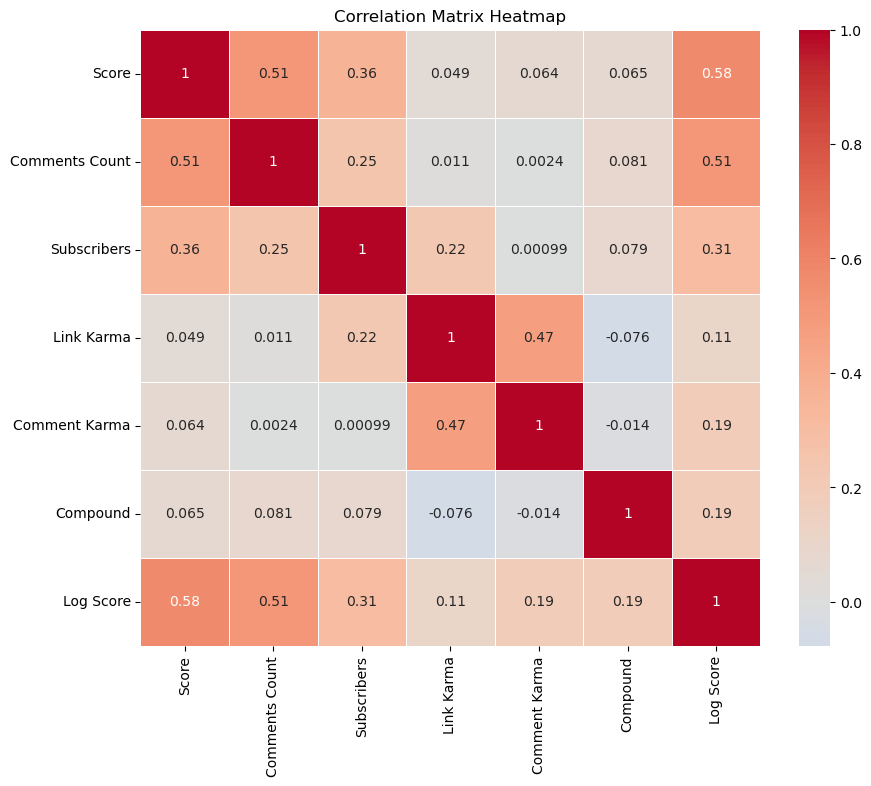

Score           Score             1.000000
Comments Count  Comments Count    1.000000
Compound        Compound          1.000000
Comment Karma   Comment Karma     1.000000
Subscribers     Subscribers       1.000000
Link Karma      Link Karma        1.000000
Log Score       Log Score         1.000000
                Score             0.576686
Score           Log Score         0.576686
Comments Count  Log Score         0.509691
Log Score       Comments Count    0.509691
Comments Count  Score             0.508505
Score           Comments Count    0.508505
dtype: float64


In [123]:
import pandas as pd

# Assuming `df` is your DataFrame with numerical variables
numerical_df = df_posts.select_dtypes(include=[np.number])
correlation_matrix = numerical_df.corr()
print(correlation_matrix)
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", center=0, linewidths=0.5)
plt.title("Correlation Matrix Heatmap")
plt.show()
# Flatten the matrix and filter correlations > 0.8 or < -0.8
high_corr_pairs = correlation_matrix.unstack().sort_values(ascending=False)
high_corr_pairs = high_corr_pairs[abs(high_corr_pairs) > 0.5]
print(high_corr_pairs)


----

In [10]:
df_posts.describe()

Score  Comments Count                   Created Date  \
count     223.000000      223.000000                            223   
mean     4207.542601      451.928251  2022-11-18 14:48:57.497758208   
min         0.000000        0.000000            2008-01-22 15:54:48   
25%        42.500000       38.000000            2021-12-13 05:46:47   
50%      1196.000000      201.000000            2023-10-06 00:27:13   
75%      4430.000000      529.500000     2024-08-25 02:56:25.500000   
max    220844.000000    15311.000000            2024-10-29 10:11:31   
std     15686.771995     1144.821924                            NaN   

        Subscribers    Link Karma  Comment Karma    Compound  
count  2.230000e+02  2.230000e+02   2.230000e+02  223.000000  
mean   4.743809e+06  5.159463e+05   5.499161e+04    0.304385  
min    0.000000e+00  1.000000e+00  -1.000000e+02   -0.999100  
25%    1.046890e+05  3.091500e+03   6.590000e+02    0.000000  
50%    1.125342e+06  1.514600e+04   5.656000e+03    0.000000  
75%    3.735539e+06  8.781600e+04   4.059600e+04    0.984200  
max    4.895558e+07  3.011631e+07   1.515024e+06    0.999900  
std    8.758628e+06  3.001634e+06   1.423178e+05    0.614677

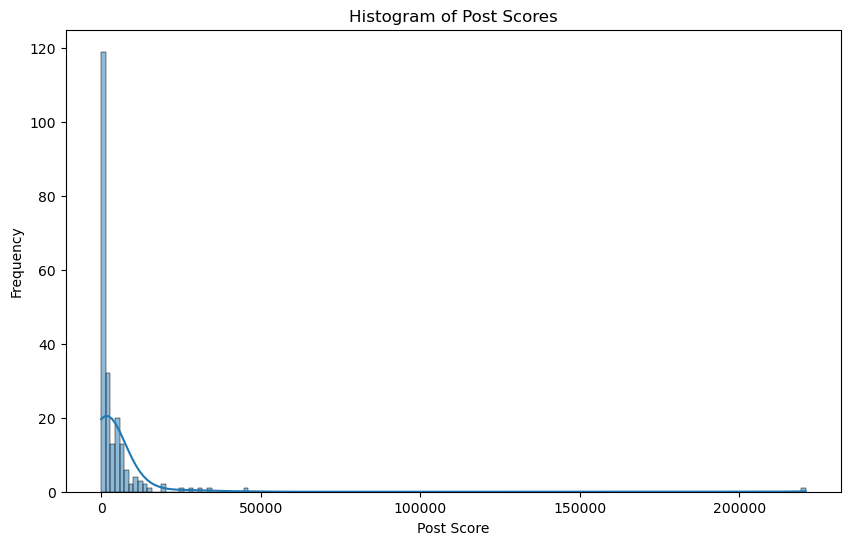

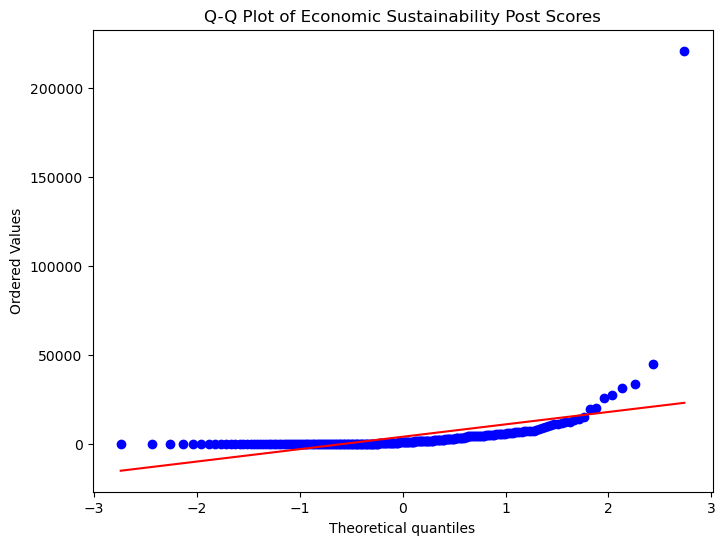

In [11]:
plt.figure(figsize=(10, 6))
sns.histplot(df_posts['Score'], kde=True)
plt.title('Histogram of Post Scores')
plt.xlabel('Post Score')
plt.ylabel('Frequency')
plt.show()

plt.figure(figsize=(8, 6))
stats.probplot(df_posts['Score'], dist="norm", plot=plt)
plt.title('Q-Q Plot of Economic Sustainability Post Scores')
plt.show()

In [12]:
shapiro_stat, shapiro_p = shapiro(df_posts['Score'])
print(f'Shapiro-Wilk Test: Statistic={shapiro_stat:.4f}, p-value={shapiro_p:.4f}')

ks_stat, ks_p = kstest(df_posts['Score'], 'norm', args=(df_posts['Score'].mean(), df_posts['Score'].std()))
print(f'Kolmogorov-Smirnov Test: Statistic={ks_stat:.4f}, p-value={ks_p:.4f}')

Shapiro-Wilk Test: Statistic=0.2057, p-value=0.0000
Kolmogorov-Smirnov Test: Statistic=0.3943, p-value=0.0000


In [13]:
data_skewness = skew(df_posts['Score'])
data_kurtosis = kurtosis(df_posts['Score'])

print(f'Skewness of Post Scores: {data_skewness:.4f}')
print(f'Kurtosis of Post Scores: {data_kurtosis:.4f}')

Skewness of Post Scores: 12.0596
Kurtosis of Post Scores: 161.9474


(12.0578): This is a very high positive skewness, indicating that the distribution of post scores is highly skewed to the right. This means that there are a few posts with very high scores that significantly pull the mean up, while most posts have relatively lower scores.

Kurtosis (161.9134): This is an extremely high kurtosis, indicating a highly leptokurtic distribution. In simpler terms, the distribution has very heavy tails, meaning that there are extreme outliers (very high or very low post scores) much more frequently than in a normal distribution. 

This could suggest that while a small number of posts garner very high engagement, most posts receive much lower scores.

In [15]:
df_posts['Log Score'] = np.log1p(df_posts['Score'])  

shapiro_stat, shapiro_p = shapiro(df_posts['Log Score'])
print(f'Log-transformed Shapiro-Wilk Test: Statistic={shapiro_stat:.4f}, p-value={shapiro_p:.4f}')

Log-transformed Shapiro-Wilk Test: Statistic=0.8965, p-value=0.0000


his value is close to 1, but not close enough to suggest normality. The test statistic being below 1 indicates some deviation from a normal distribution.

p-value = 0.0000: A p-value this small strongly suggests that the log-transformed data does not follow a normal distribution.

Despite log transformation, the post scores still significantly deviate from normality. 

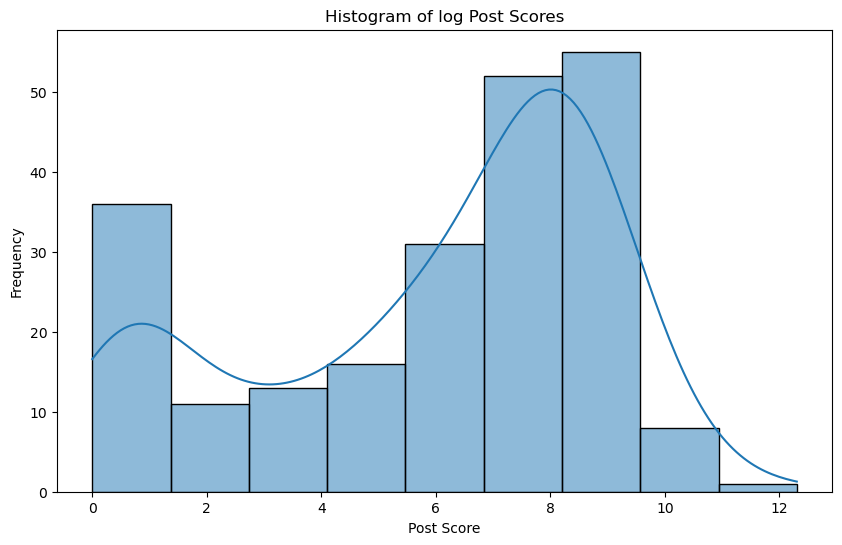

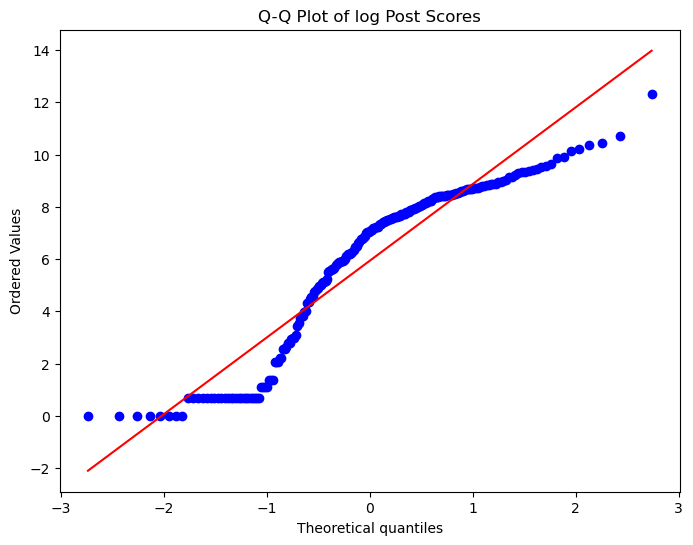

In [17]:
plt.figure(figsize=(10, 6))
sns.histplot(df_posts['Log Score'], kde=True)
plt.title('Histogram of log Post Scores')
plt.xlabel('Post Score')
plt.ylabel('Frequency')
plt.show()

plt.figure(figsize=(8, 6))
stats.probplot(df_posts['Log Score'], dist="norm", plot=plt)
plt.title('Q-Q Plot of log Post Scores')
plt.show()

Correlation between the number of posts and the average score: 0.02158700974576816


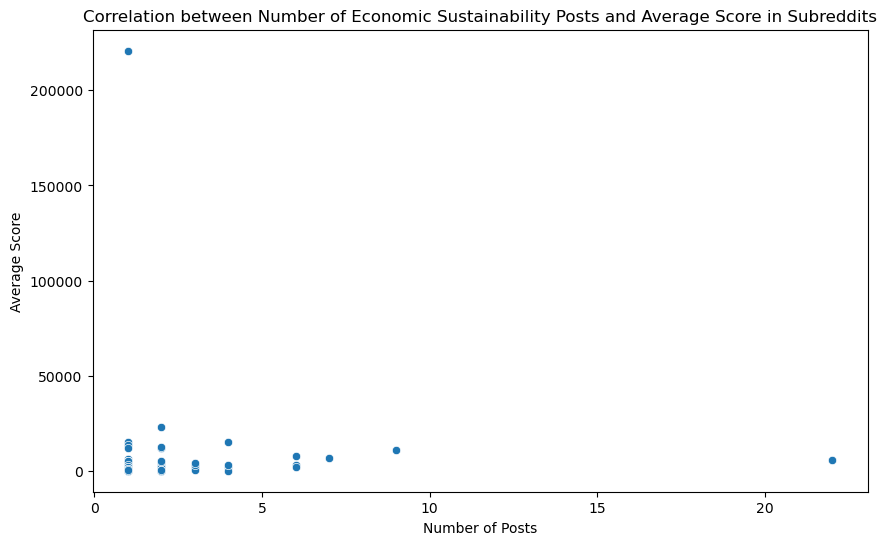

In [18]:
subreddit_stats = df_posts.groupby('Subreddit').agg(
    num_posts=('Post ID', 'count'),
    avg_score=('Score', 'mean'),
    avg_log=('Log Score', 'mean')
).reset_index()

correlation = subreddit_stats['num_posts'].corr(subreddit_stats['avg_score'])

print(f"Correlation between the number of posts and the average score: {correlation}")

plt.figure(figsize=(10,6))
sns.scatterplot(x='num_posts', y='avg_score', data=subreddit_stats)
plt.title('Correlation between Number of Economic Sustainability Posts and Average Score in Subreddits')
plt.xlabel('Number of Posts')
plt.ylabel('Average Score')
plt.show()

In [19]:
n = len(df_posts)

t_stat = correlation * np.sqrt((n - 2) / (1 - correlation**2))

p_value = stats.t.sf(np.abs(t_stat), df=n-2) * 2

print(f"Correlation coefficient: {correlation:.4f}")
print(f"t-statistic: {t_stat:.4f}")
print(f"p-value: {p_value:.4f}")

alpha = 0.05
if p_value < alpha:
    print(f"The correlation is significant (p < {alpha})")
else:
    print(f"The correlation is not significant (p ≥ {alpha})")

Correlation coefficient: 0.0216
t-statistic: 0.3210
p-value: 0.7485
The correlation is not significant (p ≥ 0.05)


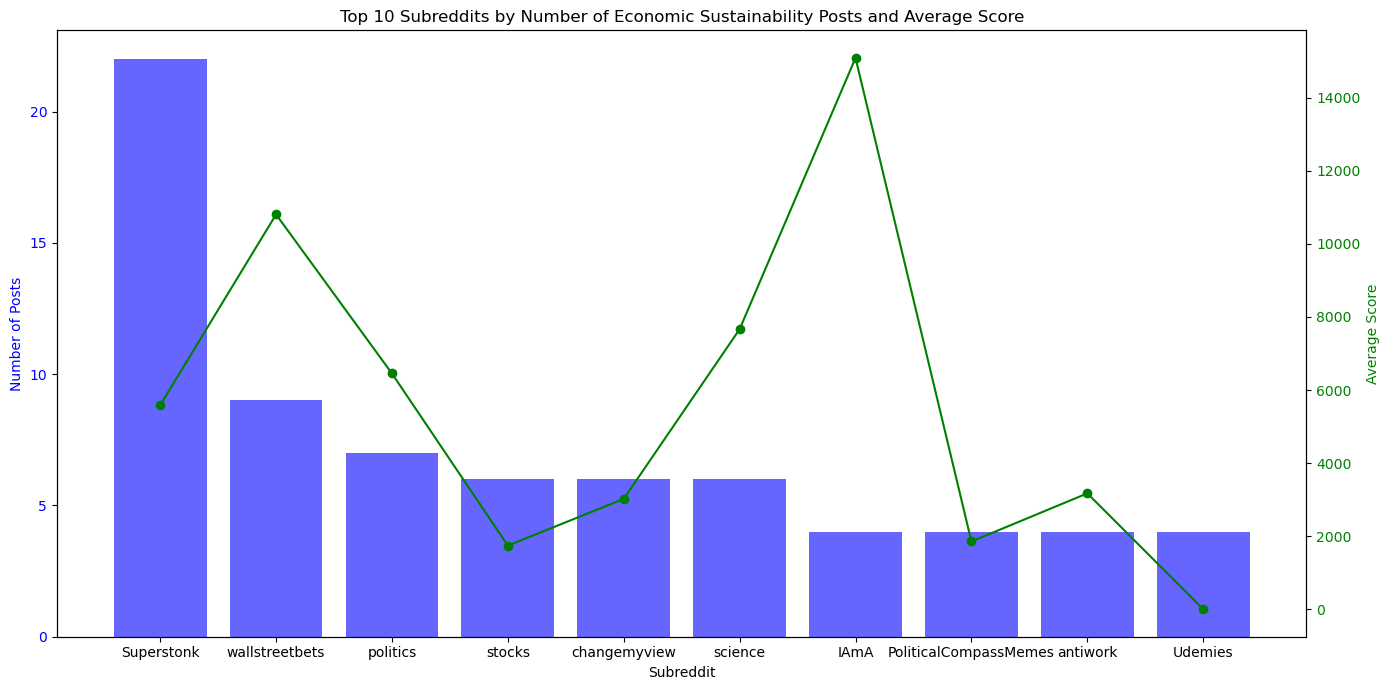

In [20]:
top_10_subreddits = subreddit_stats.sort_values(by='num_posts', ascending=False).head(10)

fig, ax1 = plt.subplots(figsize=(14,7))

ax1.set_xlabel('Subreddit')
ax1.set_ylabel('Number of Posts', color='blue')
ax1.bar(top_10_subreddits['Subreddit'], top_10_subreddits['num_posts'], color='blue', alpha=0.6)
ax1.tick_params(axis='y', labelcolor='blue')

ax2 = ax1.twinx()
ax2.set_ylabel('Average Score', color='green')
ax2.plot(top_10_subreddits['Subreddit'], top_10_subreddits['avg_score'], color='green', marker='o')
ax2.tick_params(axis='y', labelcolor='green')

plt.title('Top 10 Subreddits by Number of Economic Sustainability Posts and Average Score')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [21]:
super_posts = df_posts[df_posts['Subreddit'].str.lower() == 'superstonk']

super_posts

Post Title            Author  \
13   The Bigger Picture: Why I’m Unfazed by the Dil...     DramaCute8222   
29                               Burning Cash Part III      -einfachman-   
30                                Burning Cash Part II      -einfachman-   
35   Wycking off for OPEX: Confluence of Datasets a...         gherkinit   
42   Strange Things Volume II: Triffin's Dilemma an...     peruvian_bull   
50                                        Burning Cash      -einfachman-   
59   GME is worth $50 to $110 a share without a Squ...         redditish   
85   Hyperinflation Is Coming- The Dollar Endgame P...     peruvian_bull   
112  Hyperinflation is Coming- The Dollar Endgame P...     peruvian_bull   
118  Strange Things Volume 1: The Vanishing Bond Ma...     peruvian_bull   
130  1-Year later... The EVERYTHING Short - Mortgag...     zipitrealgood   
133               The Matrix is Everywhere. A Quant DD     BurnieSlander   
137  Fitch Downgrades the United States' Long-Term ...  Dismal-Jellyfish   
140                     Jerkin it with Gherkinit S13E3         gherkinit   
142  The possible Loopring partnership is huge, but...   ReusedBoofWater   
149         What's the deal with Reverse Repos anyway?     memebetch6969   
159                The Dollar Endgame: ADDENDUM PART 2     peruvian_bull   
167  Prelude To Total Fucking Meltdown - The Coming...          MarkLawH   
177  GameStop’s NFT Marketplace is going to be bigg...          smdauber   
182  PSYOPS ARE BEING RAN LEFT & RIGHT TO MAXIMIZE ...      hunter_weiss   
187  USA IS A TIME BOMB AND THE EXPLOSION WILL BE O...           Oncotte   
220               BlackRock & The Great Reset (Part 3)       Exceedingly   

     Score  Comments Count  Post ID  \
13    3104             679  1fe9nah   
29    8474             319  17cc2yd   
30    7212             374  16ryoqa   
35   10177            1594   sy36q8   
42    9447             634   xrdxrt   
50   11288             520   v0zrni   
59    4559             305  14zfj0k   
85    6729             447   stz5lm   
112   5925             393   ppenly   
118   5407             247   x48osc   
130   5196             266   u9sfa0   
133   5531             368   nzajpv   
137   3039             173  15frwog   
140   2108             989   rciqo0   
142   4364             345   qtvcxa   
149   6431             296   o08rmm   
159   4582             181   znipu2   
167   4458             188   ycb84d   
177   4420             274   s7akd6   
182   4565             196   wswcfl   
187   2271             112  1aokrnk   
220   3568             354   ommgb0   

                                              Post URL        Created Date  \
13   https://www.reddit.com/r/Superstonk/comments/1... 2024-09-11 15:05:55   
29   https://www.reddit.com/r/Superstonk/comments/1... 2023-10-20 16:05:06   
30   https://www.reddit.com/r/Superstonk/comments/1... 2023-09-25 19:42:35   
35   https://www.reddit.com/r/Superstonk/comments/s... 2022-02-21 21:14:45   
42   https://www.reddit.com/r/Superstonk/comments/x... 2022-09-29 19:36:27   
50   https://www.reddit.com/r/Superstonk/comments/v... 2022-05-30 15:04:14   
59   https://www.reddit.com/r/Superstonk/comments/1... 2023-07-14 14:45:57   
85   https://www.reddit.com/r/Superstonk/comments/s... 2022-02-16 16:52:57   
112  https://www.reddit.com/r/Superstonk/comments/p... 2021-09-16 16:43:28   
118  https://www.reddit.com/r/Superstonk/comments/x... 2022-09-02 20:23:34   
130  https://www.reddit.com/r/Superstonk/comments/u... 2022-04-23 02:02:22   
133  https://www.reddit.com/r/Superstonk/comments/n... 2021-06-14 02:48:34   
137  https://www.reddit.com/r/Superstonk/comments/1... 2023-08-02 01:09:15   
140  https://www.reddit.com/r/Superstonk/comments/r... 2021-12-09 15:25:16   
142  https://www.reddit.com/r/Superstonk/comments/q... 2021-11-14 18:58:29   
149  https://www.reddit.com/r/Superstonk/comments/o... 2021-06-15 09:42:03   
159  https://www.reddit.com/r/Superstonk/comments/z... 2022-12-16 17:29

In [22]:
for index, title in enumerate(super_posts['Post Title'], start=1):
    print(f"Post {index}:\n{title}")
    print("-" * 40)

Post 1:
The Bigger Picture: Why I’m Unfazed by the Dilution
----------------------------------------
Post 2:
Burning Cash Part III
----------------------------------------
Post 3:
Burning Cash Part II
----------------------------------------
Post 4:
Wycking off for OPEX: Confluence of Datasets and what drives GME's Quarterly Runs
----------------------------------------
Post 5:
Strange Things Volume II: Triffin's Dilemma and The Dollar Milkshake
----------------------------------------
Post 6:
Burning Cash
----------------------------------------
Post 7:
GME is worth $50 to $110 a share without a Squeeze.
----------------------------------------
Post 8:
Hyperinflation Is Coming- The Dollar Endgame PART 4.3, "At World's End"
----------------------------------------
Post 9:
Hyperinflation is Coming- The Dollar Endgame PART 4.1, "At World's End"
----------------------------------------
Post 10:
Strange Things Volume 1: The Vanishing Bond Market
----------------------------------------
Pos

The subreddit is deeply engaged in discussing financial markets, with a focus on GameStop (GME) and related economic phenomena.

GameStop Corp. is an American video game, consumer electronics, and gaming merchandise retailer. The company is headquartered in Grapevine, Texas, and is the largest video game retailer worldwide.

Authors are sharing detailed analyses, theories, and predictions about market behavior, potential crises, and investment strategies.
Skepticism and Warnings:

Negative sentiment posts often warn about economic downturns or unethical practices in the financial industry.
For example, posts about "Hyperinflation" and "The Vanishing Bond Market" indicate concerns about macroeconomic stability.
Optimism and Strategy:

Positive sentiment posts might express confidence in investment strategies or upcoming positive developments (e.g., "GameStop’s NFT Marketplace is going to be bigger than you think").

In [24]:
ia_posts = df_posts[df_posts['Subreddit'].str.lower() == 'iama']

ia_posts

Post Title              Author  \
47   Hello, Reddit! I am Mike Broihier - a farmer, ...        MikeBroihier   
86   Hey Reddit! My name is Paolo Cattaneo. 5 years...             paolo_0   
120  We're the self-taught development team behind ...  FromSeedToSpoonApp   
144  I bring electricity to remote villages in Afri...          tristan_ko   

     Score  Comments Count Post ID  \
47   31508            1995  fez6g9   
86    9404             733  i8zzfr   
120   6721             568  gc9agk   
144  12741             576  6bb4sc   

                                              Post URL        Created Date  \
47   https://www.reddit.com/r/IAmA/comments/fez6g9/... 2020-03-07 19:28:32   
86   https://www.reddit.com/r/IAmA/comments/i8zzfr/... 2020-08-13 15:33:37   
120  https://www.reddit.com/r/IAmA/comments/gc9agk/... 2020-05-02 18:28:33   
144  https://www.reddit.com/r/IAmA/comments/6bb4sc/... 2017-05-15 17:42:27   

    Subreddit                                          Post Text  Subscribers  \
47       IAmA  Hello, Reddit!\n\n[My name is Mike Broihier](h...     22532675   
86       IAmA  Hey there! \nI am Paolo, italian born but Aust...     22532675   
120      IAmA  Hi, we’re the founders of From Seed To Spoon! ...     22532675   
144      IAmA  EDIT4: NOW CROWDFUNDING ON GOFUNDME! --> http:...     22532675   

     Link Karma  Comment Karma  \
47        15146          17563   
86        23113          24370   
120        5091           1693   
144        5461           1454   

                                     Cleaned Post Text  \
47   hello reddit name mike broihier running u sena...   
86   hey paolo italian born australian resident sin...   
120  hi founder seed spoon started converting backy...   
144  edit crowdfunding gofundme contribute please r...   

                                      Sentiment Scores  Compound Sentiment  \
47   {'neg': 0.053, 'neu': 0.728, 'pos': 0.219, 'co...    0.9846  positive   
86   {'neg': 0.063, 'neu': 0.749, 'pos': 0.188, 'co...    0.9931  positive   
120  {'neg': 0.017, 'neu': 0.775, 'pos': 0.208, 'co...    0.9758  positive   
144  {'neg': 0.054, 'neu': 0.6, 'pos': 0.346, 'comp...    0.9967  positive   

     Log Score  
47   10.358028  
86    9.148997  
120   8.813141  
144   9.452659

In [25]:
for index, title in enumerate(ia_posts['Post Title'], start=1):
    print(f"Post {index}:\n{title}")
    print("-" * 40)

Post 1:
Hello, Reddit! I am Mike Broihier - a farmer, educator, and retired Marine LtCol running for US Senate to retire Mitch McConnell this fall in Kentucky. AMA!
----------------------------------------
Post 2:
Hey Reddit! My name is Paolo Cattaneo. 5 years ago I quit my job, sold everything I had and embarked in a trip around the world on a motorcycle. Rode for almost 185000 km (115k mi). Still going! Here to answer question about self sustained living on the road and long distance solo travelling. AmA!
----------------------------------------
Post 3:
We're the self-taught development team behind the #1 gardening app, From Seed To Spoon. Ready to answer questions about gardening from home, building software, or anything in general. Ask us anything!!!
----------------------------------------
Post 4:
I bring electricity to remote villages in Africa and got Eva Green to narrate my story. Samuel L. Jackson and other huge stars talked about it. AMA!
-------------------------------------

----

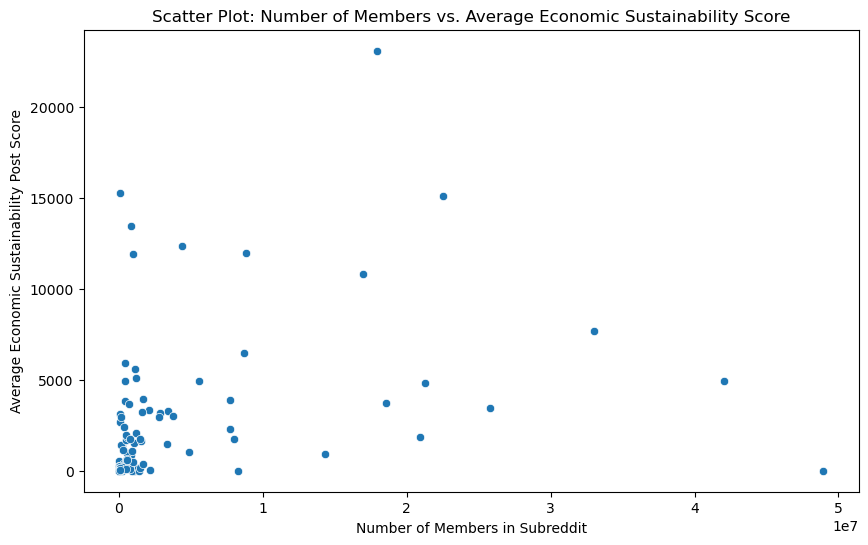

Pearson correlation coefficient: 0.3650446464468955
P-value: 2.1046232205629197e-05
Spearman correlation coefficient: 0.7006790432938697
P-value: 2.3958911486646998e-20
                            OLS Regression Results                            
Dep. Variable:     Avg_Economic_Score   R-squared:                       0.133
Model:                            OLS   Adj. R-squared:                  0.126
Method:                 Least Squares   F-statistic:                     19.53
Date:                Fri, 01 Nov 2024   Prob (F-statistic):           2.10e-05
Time:                        19:01:37   Log-Likelihood:                -1232.6
No. Observations:                 129   AIC:                             2469.
Df Residuals:                     127   BIC:                             2475.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err         

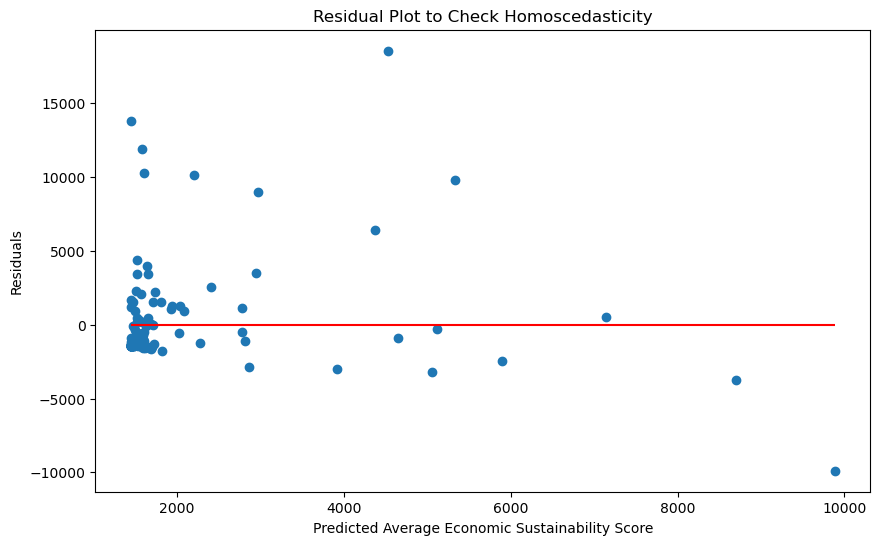

In [115]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr, spearmanr
import statsmodels.api as sm

# Assuming df_posts is your DataFrame

# Step 1: Calculate Average Economic Sustainability Post Score per Subreddit
# Assuming 'Score' represents the post score and 'Subreddit' and 'Subscribers' are columns in the data
df_avg_score = df_posts.groupby('Subreddit').agg(
    Avg_Economic_Score=('Score', 'mean'),
    Members=('Subscribers', 'first')  # Assuming 'Subscribers' is consistent for each subreddit
).reset_index()

# Step 2: Scatter Plot - Members vs. Average Economic Sustainability Score
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_avg_score, x='Members', y='Avg_Economic_Score')
plt.xlabel('Number of Members in Subreddit')
plt.ylabel('Average Economic Sustainability Post Score')
plt.title('Scatter Plot: Number of Members vs. Average Economic Sustainability Score')
plt.show()

# Step 3: Pearson Correlation
pearson_corr, pearson_p = pearsonr(df_avg_score['Members'], df_avg_score['Avg_Economic_Score'])
print(f"Pearson correlation coefficient: {pearson_corr}")
print(f"P-value: {pearson_p}")

# Step 4: Spearman Correlation (Non-parametric alternative)
spearman_corr, spearman_p = spearmanr(df_avg_score['Members'], df_avg_score['Avg_Economic_Score'])
print(f"Spearman correlation coefficient: {spearman_corr}")
print(f"P-value: {spearman_p}")

# Step 5: Fit a Linear Model and Check Residuals
# Adding a constant to the Members for intercept in regression
X = sm.add_constant(df_avg_score['Members'])
model = sm.OLS(df_avg_score['Avg_Economic_Score'], X).fit()
print(model.summary())

# Residual Plot to Check Homoscedasticity
predictions = model.predict(X)
residuals = df_avg_score['Avg_Economic_Score'] - predictions

plt.figure(figsize=(10, 6))
plt.scatter(predictions, residuals)
plt.hlines(0, min(predictions), max(predictions), colors='red')
plt.xlabel('Predicted Average Economic Sustainability Score')
plt.ylabel('Residuals')
plt.title('Residual Plot to Check Homoscedasticity')
plt.show()


The low R-squared value, along with the residual plot’s pattern, indicates that a linear relationship might not be the best model for the data. There may be non-linear patterns or interactions that a simple linear regression cannot capture.

----------

Correlation between the number of members (subscribers) and the average score: 0.24273284542464468


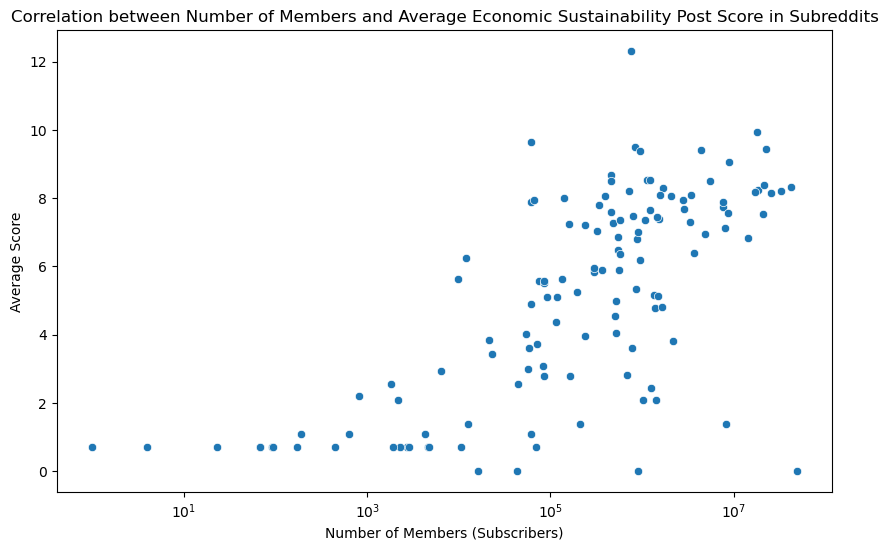

In [26]:
subreddit_stats = df_posts.groupby('Subreddit').agg(
    num_posts=('Post ID', 'count'),
    avg_score=('Log Score', 'mean'),
    subscribers=('Subscribers', 'first'),
    avg_log=('Log Score', 'mean')# Get the subscriber count for each subreddit
).reset_index()

correlation = subreddit_stats['subscribers'].corr(subreddit_stats['avg_score'])

print(f"Correlation between the number of members (subscribers) and the average score: {correlation}")

plt.figure(figsize=(10,6))
sns.scatterplot(x='subscribers', y='avg_score', data=subreddit_stats)
plt.title('Correlation between Number of Members and Average Economic Sustainability Post Score in Subreddits')
plt.xlabel('Number of Members (Subscribers)')
plt.ylabel('Average Score')
plt.xscale('log')  
plt.show()

In [27]:
n = len(df_posts)

t_stat = correlation * np.sqrt((n - 2) / (1 - correlation**2))

p_value = stats.t.sf(np.abs(t_stat), df=n-2) * 2  # two-tailed test

print(f"Correlation coefficient: {correlation:.4f}")
print(f"t-statistic: {t_stat:.4f}")
print(f"p-value: {p_value:.4f}")

alpha = 0.05
if p_value < alpha:
    print(f"The correlation is significant (p < {alpha})")
else:
    print(f"The correlation is not significant (p ≥ {alpha})")

Correlation coefficient: 0.2427
t-statistic: 3.7197
p-value: 0.0003
The correlation is significant (p < 0.05)


In [28]:
spearman_corr, spearman_p = spearmanr(subreddit_stats['subscribers'], subreddit_stats['avg_score'])
print(f"Spearman's Rank Correlation: {spearman_corr:.4f}, p-value: {spearman_p:.4f}")

# Kendall's Tau Correlation
kendall_corr, kendall_p = kendalltau(subreddit_stats['subscribers'], subreddit_stats['avg_score'])
print(f"Kendall's Tau Correlation: {kendall_corr:.4f}, p-value: {kendall_p:.4f}")

Spearman's Rank Correlation: 0.6708, p-value: 0.0000
Kendall's Tau Correlation: 0.5093, p-value: 0.0000


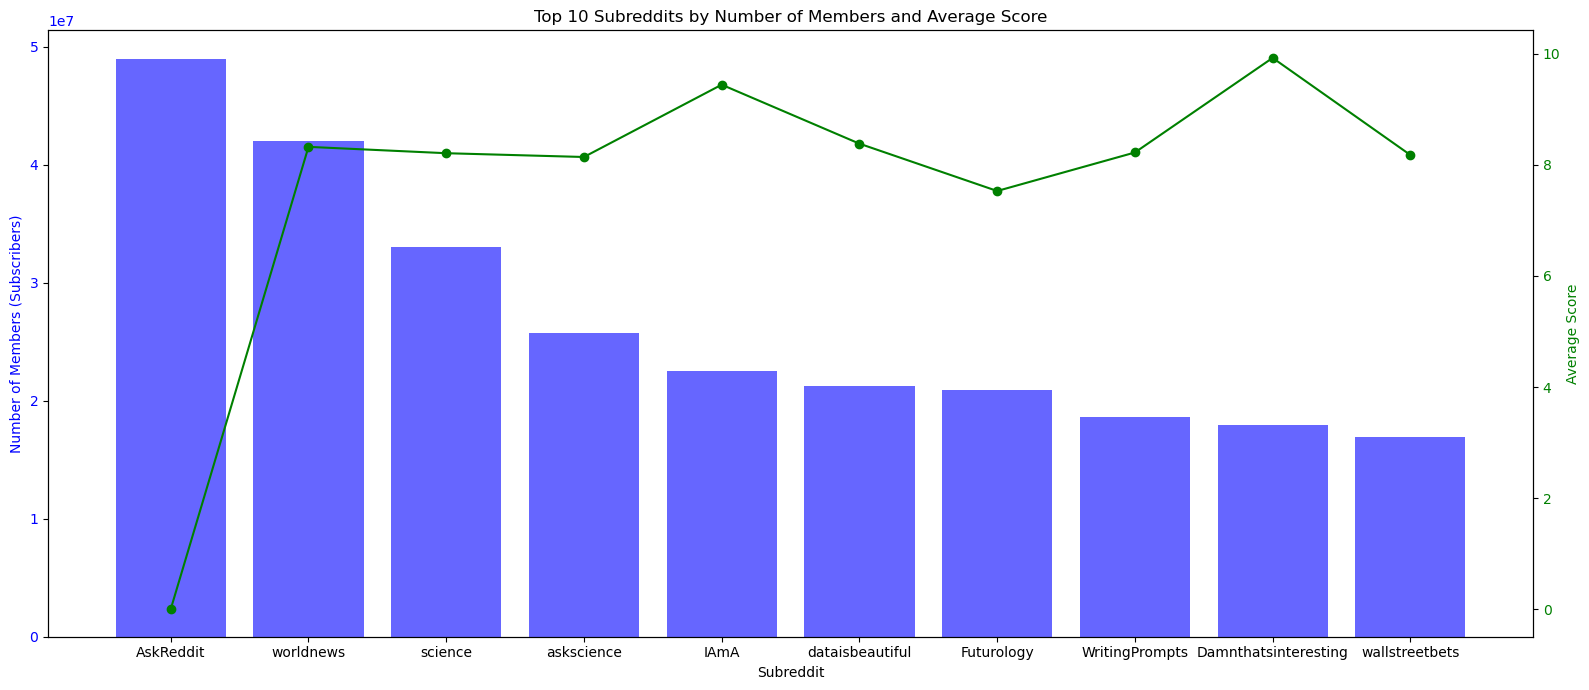

In [29]:
top_10_subreddits = subreddit_stats.sort_values(by='subscribers', ascending=False).head(10)

fig, ax1 = plt.subplots(figsize=(16,7))

ax1.set_xlabel('Subreddit')
ax1.set_ylabel('Number of Members (Subscribers)', color='blue')
ax1.bar(top_10_subreddits['Subreddit'], top_10_subreddits['subscribers'], color='blue', alpha=0.6)
ax1.tick_params(axis='y', labelcolor='blue')

ax2 = ax1.twinx()
ax2.set_ylabel('Average Score', color='green')
ax2.plot(top_10_subreddits['Subreddit'], top_10_subreddits['avg_score'], color='green', marker='o')
ax2.tick_params(axis='y', labelcolor='green')

plt.title('Top 10 Subreddits by Number of Members and Average Score')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [30]:
ask_posts = df_posts[df_posts['Subreddit'].str.lower() == 'askreddit']

ask_posts

Post Title           Author  \
124  How can we create a global economic system tha...  RemoteMajor9739   

     Score  Comments Count  Post ID  \
124      0              16  1easfnr   

                                              Post URL        Created Date  \
124  https://www.reddit.com/r/AskReddit/comments/1e... 2024-07-24 06:22:51   

     Subreddit Post Text  Subscribers  Link Karma  Comment Karma  \
124  AskReddit       N/A     48955577           1              0   

    Cleaned Post Text                                   Sentiment Scores  \
124                 n  {'neg': 0.0, 'neu': 0.0, 'pos': 0.0, 'compound...   

     Compound Sentiment  Log Score  
124       0.0   neutral        0.0

In [31]:
for index, title in enumerate(ask_posts['Post Title'], start=1):
    print(f"Post {index}:\n{title}")

Post 1:
How can we create a global economic system that prioritizes both human well-being and environmental sustainability? What radical changes would need to occur to balance economic growth with social equity and ecological preservation?


In [32]:
damn_posts = df_posts[df_posts['Subreddit'].str.lower() == 'damnthatsinteresting']

damn_posts

Post Title       Author  Score  \
41  This looks like plastic, feels like plastic, b...      Kronyzx  33776   
44  Empty Oil drums is exchange for fruits and veg...  nomar_ramon  12382   

    Comments Count  Post ID                         Post URL  \
41             729   rgfr8x  https://v.redd.it/230kikygck581   
44              97  1d1yxgm  https://v.redd.it/abrphuvwm03d1   

          Created Date             Subreddit Post Text  Subscribers  \
41 2021-12-14 20:55:33  Damnthatsinteresting       N/A     17905507   
44 2024-05-27 20:53:35  Damnthatsinteresting       N/A     17905504   

    Link Karma  Comment Karma Cleaned Post Text  \
41     1081647          20252                 n   
44      334894          66023                 n   

                                     Sentiment Scores  Compound Sentiment  \
41  {'neg': 0.0, 'neu': 0.0, 'pos': 0.0, 'compound...       0.0   neutral   
44  {'neg': 0.0, 'neu': 0.0, 'pos': 0.0, 'compound...       0.0   neutral   

    Log Score  
41  10.427535  
44   9.424080

In [33]:
for index, title in enumerate(damn_posts['Post Title'], start=1):
    print(f"Post {index}:\n{title}")
    print("-" * 40)

Post 1:
This looks like plastic, feels like plastic, but it isn't. This biodegradable bioplastic (Sonali Bag) is made from a plant named jute and invented by a Bangladeshi Scientist Mubarak Ahmed Khan. This can solve the Global Plastic Pollution problem.
----------------------------------------
Post 2:
Empty Oil drums is exchange for fruits and vegetables 
----------------------------------------


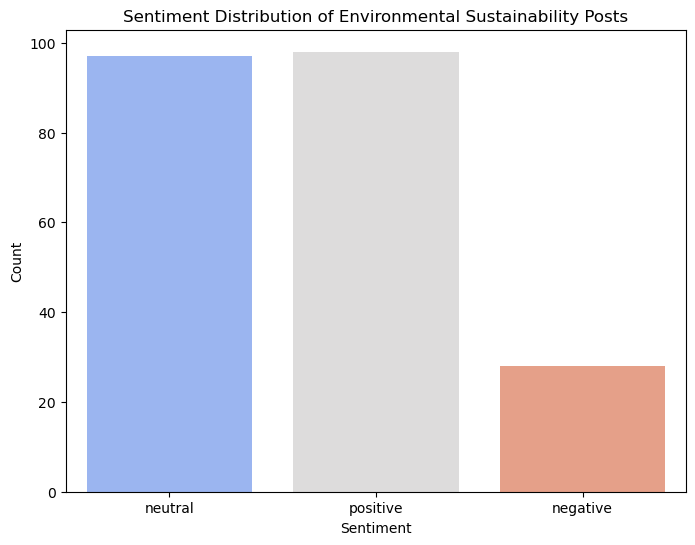

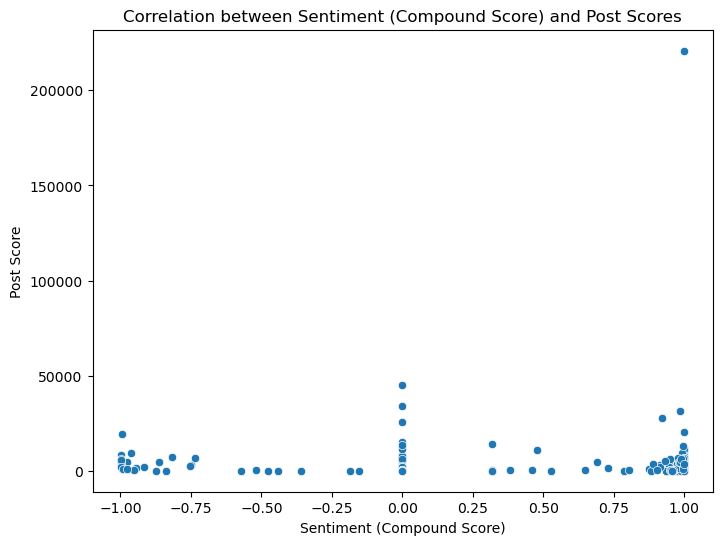

Correlation between sentiment (compound score) and post scores: 0.09


In [34]:
plt.figure(figsize=(8, 6))
sns.countplot(x='Sentiment', data=df_posts, palette='coolwarm')
plt.title('Sentiment Distribution of Environmental Sustainability Posts')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()
plt.figure(figsize=(8, 6))
sns.scatterplot(x='Compound', y='Score', data=df_posts)
plt.title('Correlation between Sentiment (Compound Score) and Post Scores')
plt.xlabel('Sentiment (Compound Score)')
plt.ylabel('Post Score')
plt.show()
correlation = df_posts['Compound'].corr(df_posts['Score'])
print(f'Correlation between sentiment (compound score) and post scores: {correlation:.2f}')

In [35]:
n = len(df_posts)

t_stat = correlation * np.sqrt((n - 2) / (1 - correlation**2))

p_value = stats.t.sf(np.abs(t_stat), df=n-2) * 2  # two-tailed test

print(f"Correlation coefficient: {correlation:.4f}")
print(f"t-statistic: {t_stat:.4f}")
print(f"p-value: {p_value:.4f}")

alpha = 0.05
if p_value < alpha:
    print(f"The correlation is significant (p < {alpha})")
else:
    print(f"The correlation is not significant (p ≥ {alpha})")

Correlation coefficient: 0.0948
t-statistic: 1.4155
p-value: 0.1583
The correlation is not significant (p ≥ 0.05)


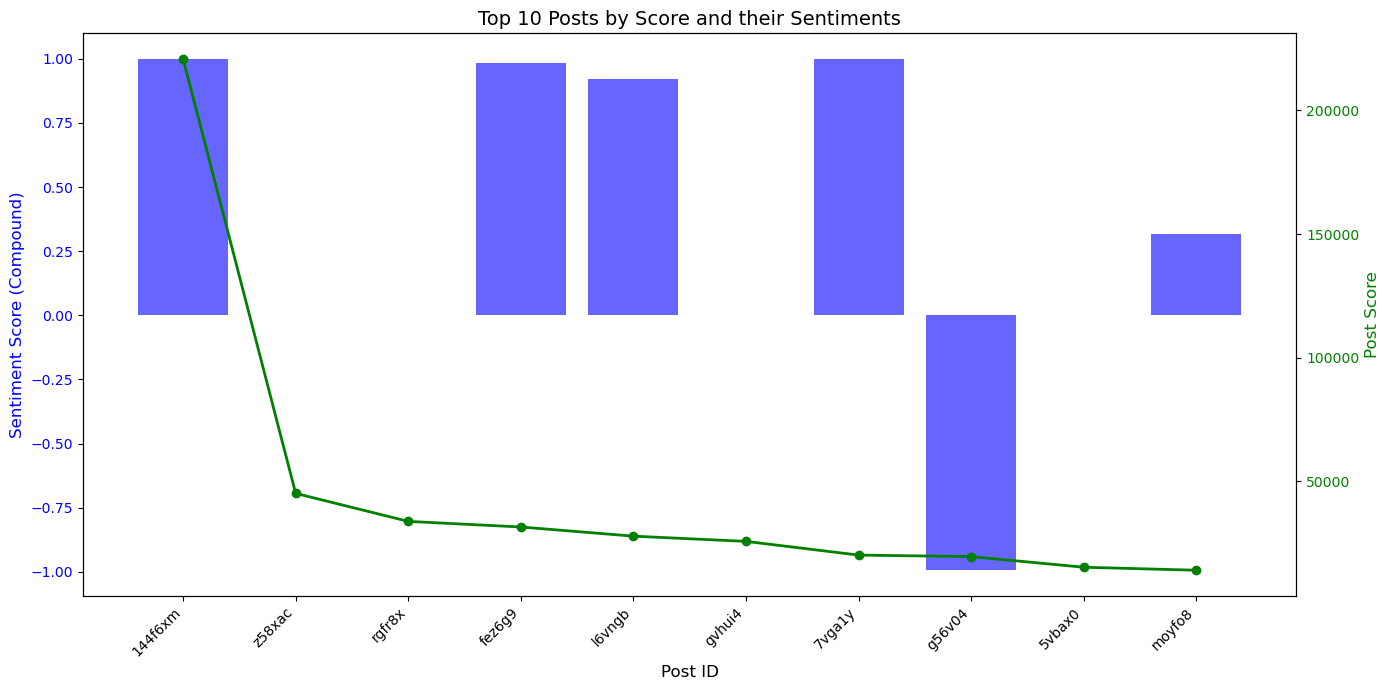

In [36]:
top_10_posts = df_posts.sort_values(by='Score', ascending=False).head(10)

fig, ax1 = plt.subplots(figsize=(14,7))

ax1.set_xlabel('Post ID', fontsize=12)
ax1.set_ylabel('Sentiment Score (Compound)', color='blue', fontsize=12)
ax1.bar(top_10_posts['Post ID'], top_10_posts['Compound'], color='blue', alpha=0.6)
ax1.tick_params(axis='y', labelcolor='blue')

plt.xticks(rotation=45, ha='right')

ax2 = ax1.twinx()
ax2.set_ylabel('Post Score', color='green', fontsize=12)
ax2.plot(top_10_posts['Post ID'], top_10_posts['Score'], color='green', marker='o', linewidth=2)
ax2.tick_params(axis='y', labelcolor='green')

plt.title('Top 10 Posts by Score and their Sentiments', fontsize=14)

plt.tight_layout()

plt.show()

In [37]:
top_10_posts

Post Title                Author  \
10  📣 Apollo will close down on June 30th. Reddit’...             iamthatis   
22  WSJ fixed the headline, can you fix the rest o...      Special_Yam_1174   
41  This looks like plastic, feels like plastic, b...               Kronyzx   
47  Hello, Reddit! I am Mike Broihier - a farmer, ...          MikeBroihier   
49                           Reddit is saving America  66_Percent_Brad_Pitt   
76  During the Reconstruction-era, the election of...         smurfyjenkins   
82  I will tell you exactly what is going on here,...             Suuperdad   
45  Megathread: President Donald Trump To Sign Exe...  PoliticsModeratorBot   
0   Opinion | The Trump White House is already coo...            Ralphdraw3   
60  Living an environmentally friendly life is a p...          WantedHHHJJJ   

     Score  Comments Count  Post ID  \
10  220844           15311  144f6xm   
22   45105            1496   z58xac   
41   33776             729   rgfr8x   
47   31508            1995   fez6g9   
49   27801             874   l6vngb   
76   25691             624   gvhui4   
82   20147            1419   7vga1y   
45   19526            5333   g56v04   
0    15234             693   5vbax0   
60   14016             759   moyfo8   

                                             Post URL        Created Date  \
10  https://www.reddit.com/r/apolloapp/comments/14... 2023-06-08 19:18:52   
22                https://i.redd.it/q331zk943b2a1.jpg 2022-11-26 15:33:39   
41                    https://v.redd.it/230kikygck581 2021-12-14 20:55:33   
47  https://www.reddit.com/r/IAmA/comments/fez6g9/... 2020-03-07 19:28:32   
49  https://www.reddit.com/r/wallstreetbets/commen... 2021-01-28 13:41:50   
76  https://www.cambridge.org/core/journals/journa... 2020-06-03 00:51:59   
82  https://www.reddit.com/r/CryptoCurrency/commen... 2018-02-05 18:21:09   
45  https://www.reddit.com/r/politics/comments/g56... 2020-04-21 04:31:52   
0   https://www.washingtonpost.com/opinions/the-tr... 2017-02-21 13:50:58   
60  https://www.reddit.com/r/unpopularopinion/comm... 2021-04-11 22:16:34   

               Subreddit                                          Post Text  \
10             apolloapp  Hey all,\n\nIt's been an amazing run thanks to...   
22        wallstreetbets                                                N/A   
41  Damnthatsinteresting                                                N/A   
47                  IAmA  Hello, Reddit!\n\n[My name is Mike Broihier](h...   
49        wallstreetbets  Can we just pause for a minute and think of th...   
76               science                                                N/A   
82        CryptoCurrency  /edit: Hi /r/all. While I have your attention,...   
45              politics  President Trump on Monday said he will sign an...   
0          Impeach_Trump                                                N/A   
60      unpopularopinion  Many poor people do not have the financial cap...   

    Subscribers  Link Karma  Comment Karma  \
10       758905      529042         607499   
22     16957862      170799           2020   
41     17905507     1081647          20252   
47     22532675       15146          17563   
49     16957863        7684           5520   
76     33031273     1921691          59354   
82      8861562       66668         358645   
45      8685726     4073706           -100   
0         60731      305229          25182   
60      4389220        6395           3504   

                                    Cleaned Post Text  \
10  hey amazing run thanks eight year ago posted a...   
22                                                  n   
41                                                  n   
47  hello reddit name mike broihier running u sena...   
49  pause minute think magnitude forum impact glob...   
76                                                  n   
82  edit hi r attention want take second time brin...   
45  president trump monday said sign executive ord...   
0    

In [38]:
full_title = top_10_posts.loc[top_10_posts['Post ID'] == '144f6xm', 'Post Title'].values[0]
print(full_title)

📣 Apollo will close down on June 30th. Reddit’s recent decisions and actions have unfortunately made it impossible for Apollo to continue. Thank you so, so much for all the support over the years. ❤️


Not related, let's remove

In [40]:
df_posts = df_posts.drop(index=10)

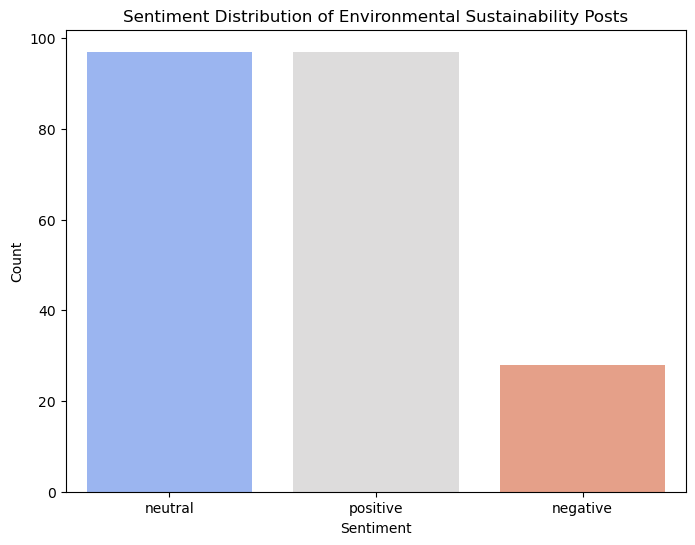

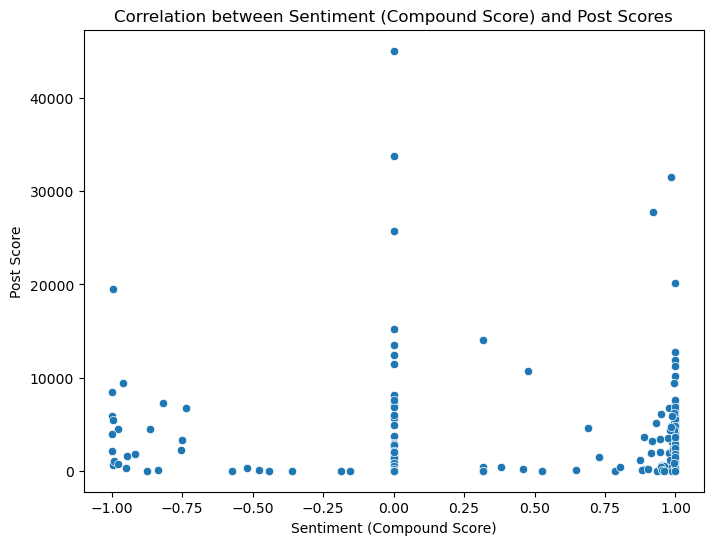

Correlation between sentiment (compound score) and post scores: 0.07
Correlation coefficient: 0.0652
t-statistic: 0.9698
p-value: 0.3332
The correlation is not significant (p ≥ 0.05)


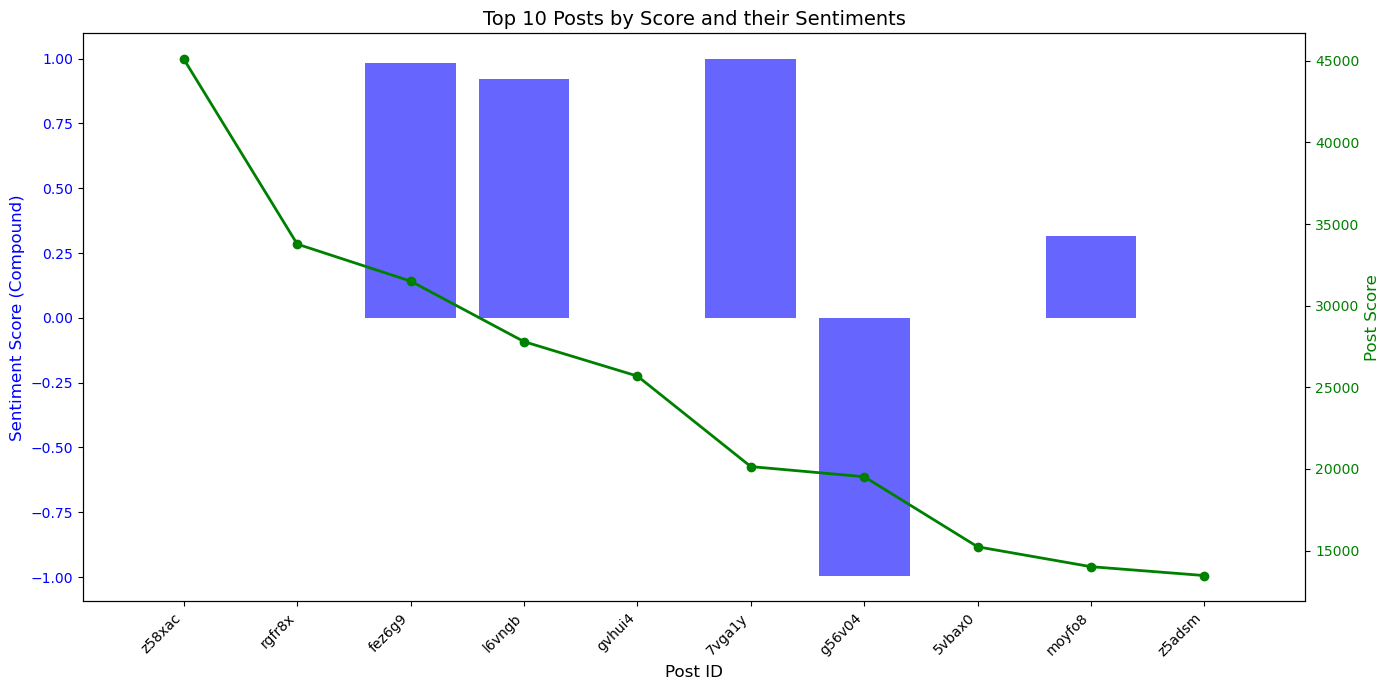

Post Title                Author  \
22   WSJ fixed the headline, can you fix the rest o...      Special_Yam_1174   
41   This looks like plastic, feels like plastic, b...               Kronyzx   
47   Hello, Reddit! I am Mike Broihier - a farmer, ...          MikeBroihier   
49                            Reddit is saving America  66_Percent_Brad_Pitt   
76   During the Reconstruction-era, the election of...         smurfyjenkins   
82   I will tell you exactly what is going on here,...             Suuperdad   
45   Megathread: President Donald Trump To Sign Exe...  PoliticsModeratorBot   
0    Opinion | The Trump White House is already coo...            Ralphdraw3   
60   Living an environmentally friendly life is a p...          WantedHHHJJJ   
103  REMINDER: Just 37 years ago, there were 50 com...               digital   

     Score  Comments Count Post ID  \
22   45105            1496  z58xac   
41   33776             729  rgfr8x   
47   31508            1995  fez6g9   
49   27801             874  l6vngb   
76   25691             624  gvhui4   
82   20147            1419  7vga1y   
45   19526            5333  g56v04   
0    15234             693  5vbax0   
60   14016             759  moyfo8   
103  13473             167  z5adsm   

                                              Post URL        Created Date  \
22                 https://i.redd.it/q331zk943b2a1.jpg 2022-11-26 15:33:39   
41                     https://v.redd.it/230kikygck581 2021-12-14 20:55:33   
47   https://www.reddit.com/r/IAmA/comments/fez6g9/... 2020-03-07 19:28:32   
49   https://www.reddit.com/r/wallstreetbets/commen... 2021-01-28 13:41:50   
76   https://www.cambridge.org/core/journals/journa... 2020-06-03 00:51:59   
82   https://www.reddit.com/r/CryptoCurrency/commen... 2018-02-05 18:21:09   
45   https://www.reddit.com/r/politics/comments/g56... 2020-04-21 04:31:52   
0    https://www.washingtonpost.com/opinions/the-tr... 2017-02-21 13:50:58   
60   https://www.reddit.com/r/unpopularopinion/comm... 2021-04-11 22:16:34   
103                https://i.redd.it/elhqf9lvwc2a1.jpg 2022-11-26 16:40:12   

                Subreddit                                          Post Text  \
22         wallstreetbets                                                N/A   
41   Damnthatsinteresting                                                N/A   
47                   IAmA  Hello, Reddit!\n\n[My name is Mike Broihier](h...   
49         wallstreetbets  Can we just pause for a minute and think of th...   
76                science                                                N/A   
82         CryptoCurrency  /edit: Hi /r/all. While I have your attention,...   
45               politics  President Trump on Monday said he will sign an...   
0           Impeach_Trump                                                N/A   
60       unpopularopinion  Many poor people do not have the financial cap...   
103   LateStageCapitalism                                                N/A   

     Subscribers  Link Karma  Comment Karma  \
22      16957862      170799           2020   
41      17905507     1081647          20252   
47      22532675       15146          17563   
49      16957863        7684           5520   
76      33031273     1921691          59354   
82       8861562       66668         358645   
45       8685726     4073706           -100   
0          60731      305229          25182   
60       4389220        6395           3504   
103       833184      412973          60338   

                                     Cleaned Post Text  \
22                                                   n   
41                                                   n   
47   hello reddit name mike broihier running u sena...   
49   pause minute think magnitude forum impact glob...   
76                                                   n   
82   edit hi r attention want take second time brin...   
45   president trump monday said sign executive ord...   
0                     

In [41]:
plt.figure(figsize=(8, 6))
sns.countplot(x='Sentiment', data=df_posts, palette='coolwarm')
plt.title('Sentiment Distribution of Environmental Sustainability Posts')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()
plt.figure(figsize=(8, 6))
sns.scatterplot(x='Compound', y='Score', data=df_posts)
plt.title('Correlation between Sentiment (Compound Score) and Post Scores')
plt.xlabel('Sentiment (Compound Score)')
plt.ylabel('Post Score')
plt.show()
correlation = df_posts['Compound'].corr(df_posts['Score'])
print(f'Correlation between sentiment (compound score) and post scores: {correlation:.2f}')

n = len(df_posts)

t_stat = correlation * np.sqrt((n - 2) / (1 - correlation**2))

p_value = stats.t.sf(np.abs(t_stat), df=n-2) * 2  # two-tailed test

print(f"Correlation coefficient: {correlation:.4f}")
print(f"t-statistic: {t_stat:.4f}")
print(f"p-value: {p_value:.4f}")

alpha = 0.05
if p_value < alpha:
    print(f"The correlation is significant (p < {alpha})")
else:
    print(f"The correlation is not significant (p ≥ {alpha})")
    
top_10_posts = df_posts.sort_values(by='Score', ascending=False).head(10)

fig, ax1 = plt.subplots(figsize=(14,7))

ax1.set_xlabel('Post ID', fontsize=12)
ax1.set_ylabel('Sentiment Score (Compound)', color='blue', fontsize=12)
ax1.bar(top_10_posts['Post ID'], top_10_posts['Compound'], color='blue', alpha=0.6)
ax1.tick_params(axis='y', labelcolor='blue')

plt.xticks(rotation=45, ha='right')

ax2 = ax1.twinx()
ax2.set_ylabel('Post Score', color='green', fontsize=12)
ax2.plot(top_10_posts['Post ID'], top_10_posts['Score'], color='green', marker='o', linewidth=2)
ax2.tick_params(axis='y', labelcolor='green')

plt.title('Top 10 Posts by Score and their Sentiments', fontsize=14)

plt.tight_layout()

plt.show()

top_10_posts

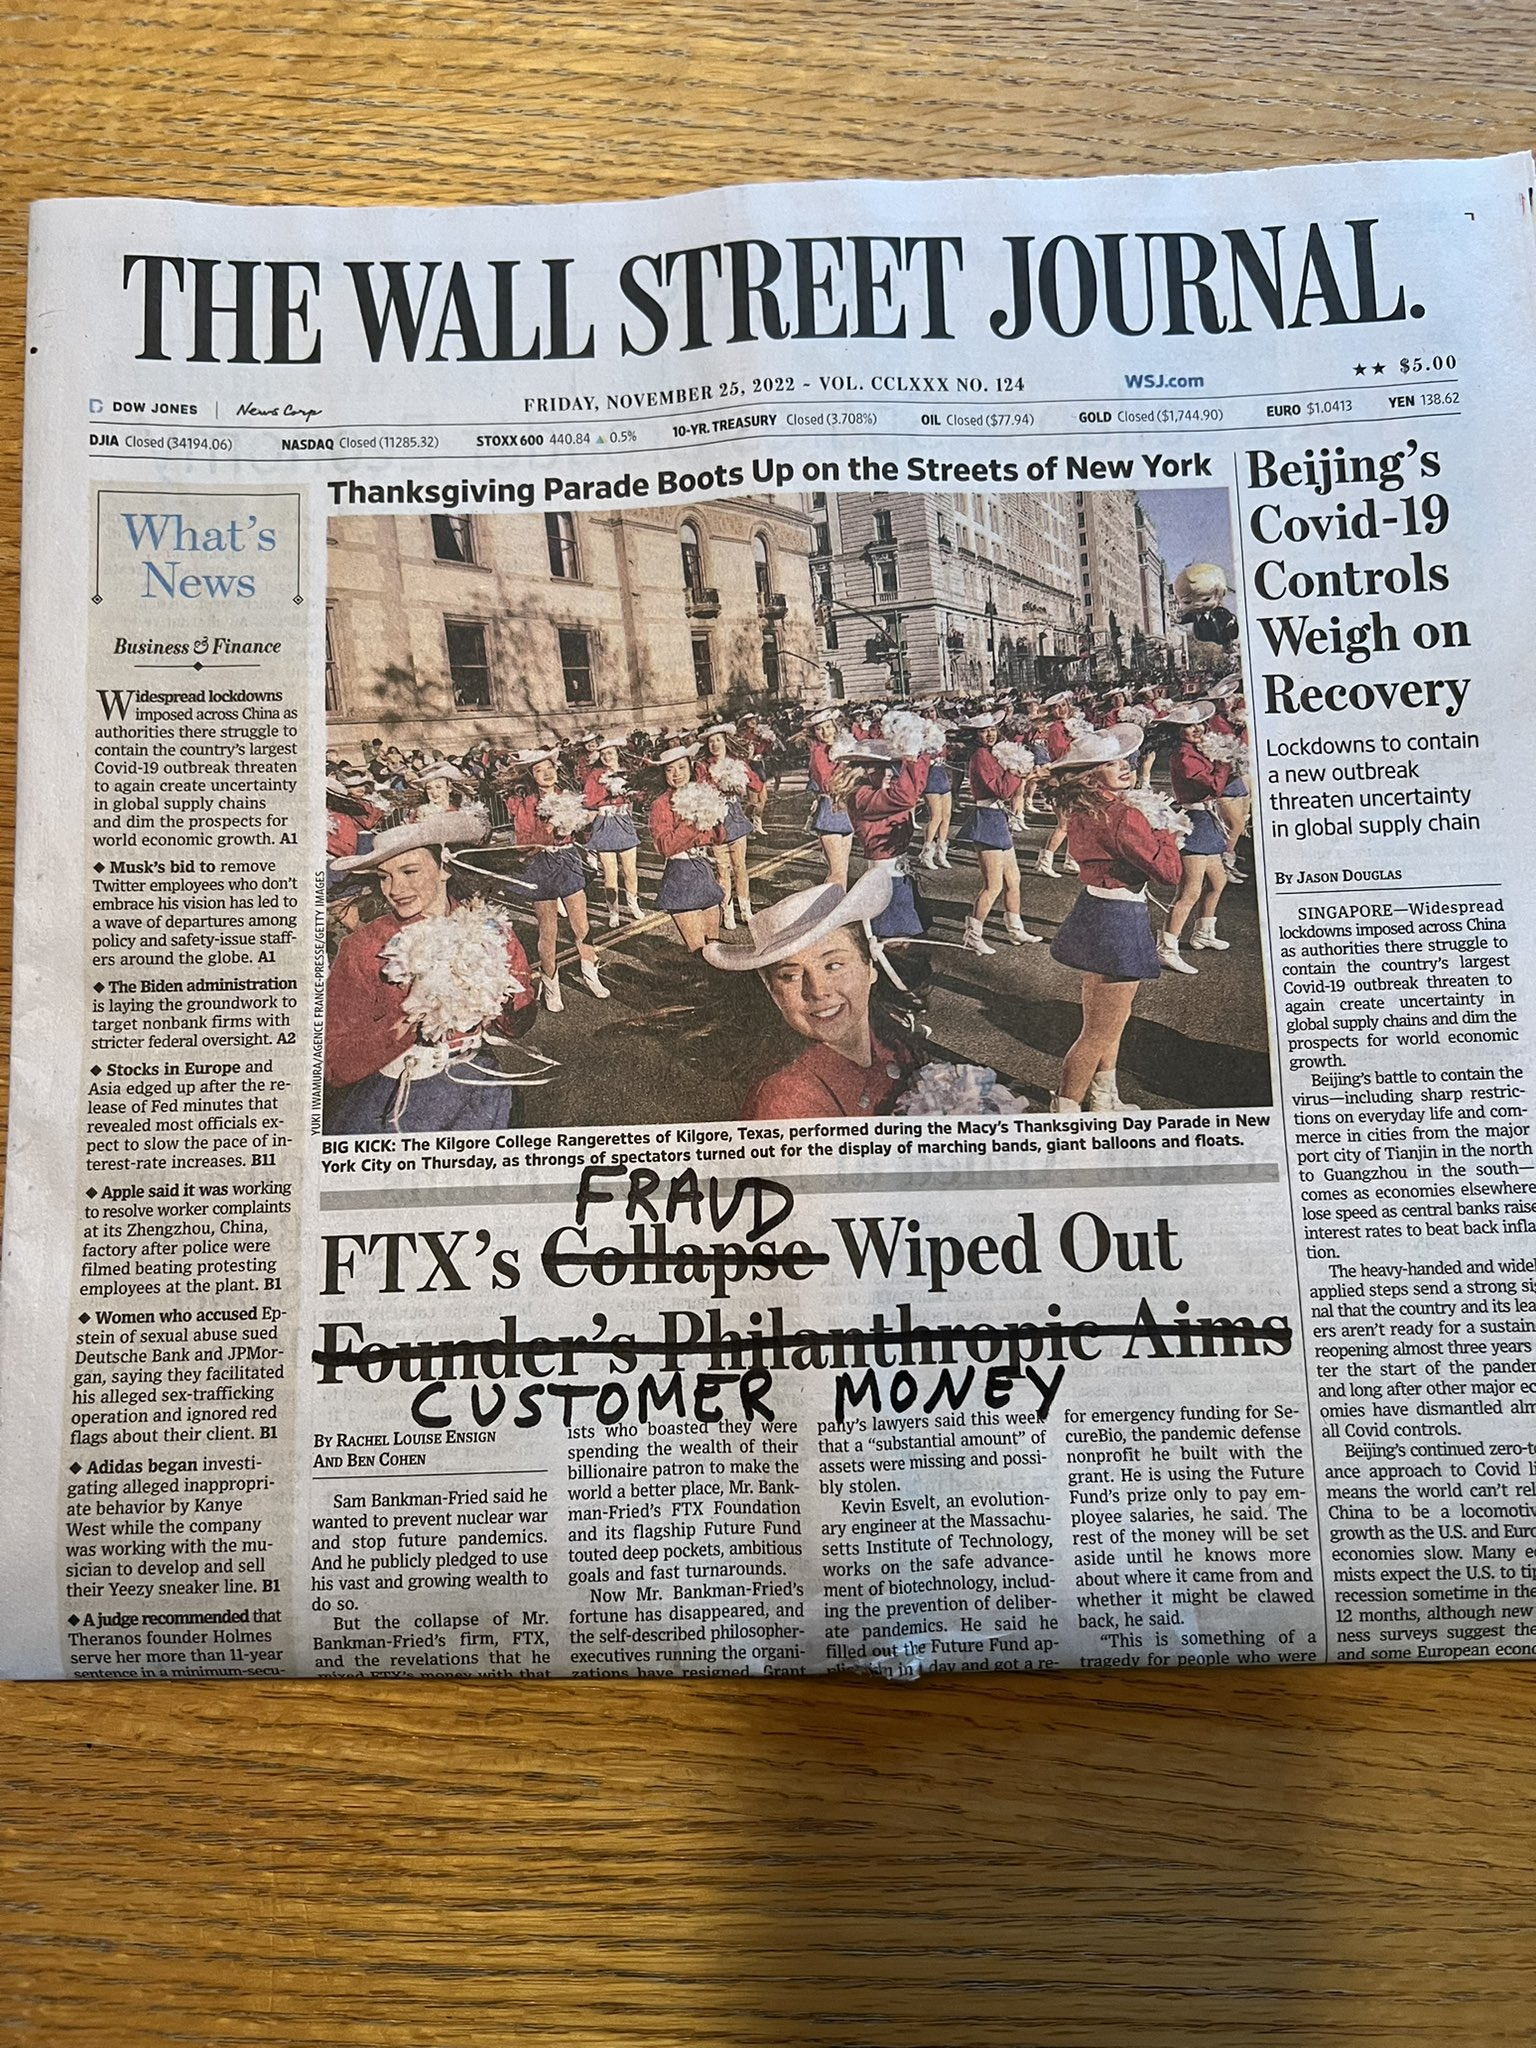

In [43]:

def fetch_post_text(subreddit, post_id):
    # Fetch the submission object using subreddit and post ID
    submission = reddit.submission(id=post_id)
    
    # Fetch the post text (body of the post)
    if submission.selftext:
        return submission.selftext
    else:
        return "This post has no text (it may be a link or media)."

In [44]:

post_text = fetch_post_text('Politics', 'g56v04')
print("Post Text:", post_text[:1000])

Post Text: President Trump on Monday said he will sign an executive order to temporarily suspend immigration into the United States amid the coronavirus pandemic, a move that is likely to draw prompt legal challenges.

"In light of the attack from the Invisible Enemy, as well as the need to protect the jobs of our GREAT American Citizens, I will be signing an Executive Order to temporarily suspend immigration into the United States!" Trump tweeted.

---

##Submissions that may interest you

SUBMISSION | DOMAIN
---|----
[Trump says he will sign executive order temporarily suspending immigration into US](https://thehill.com/homenews/administration/493812-trump-says-he-will-sign-executive-order-temporarily-suspending) | thehill.com
[Trump says he is suspending immigration over coronavirus, need to protect jobs](https://www.nbcnews.com/politics/donald-trump/trump-says-he-suspending-immigration-over-coronavirus-need-protect-jobs-n1188416) | nbcnews.com
[Trump says will sign order to tempora

In [45]:
author_avg_score = df_posts.groupby('Author')['Score'].mean().reset_index()
author_avg_score.columns = ['Author', 'Avg_Score']

author_karma_data = df_posts[['Author', 'Link Karma', 'Comment Karma']].drop_duplicates()

author_stats = pd.merge(author_avg_score, author_karma_data, on='Author', how='inner')

correlation_matrix = author_stats[['Avg_Score', 'Link Karma', 'Comment Karma']].corr()

print(correlation_matrix)

               Avg_Score  Link Karma  Comment Karma
Avg_Score       1.000000    0.066961       0.037728
Link Karma      0.066961    1.000000       0.503451
Comment Karma   0.037728    0.503451       1.000000


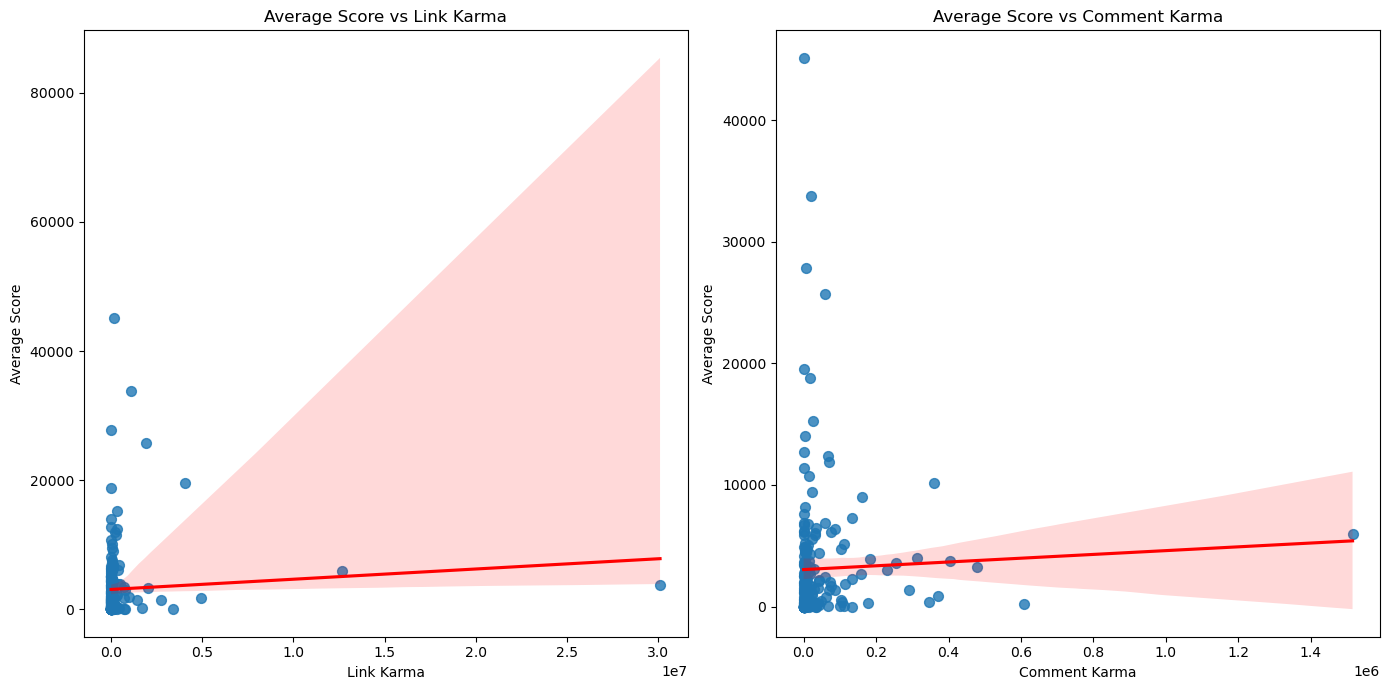

In [46]:
plt.figure(figsize=(14, 7))

plt.subplot(1, 2, 1)
sns.regplot(x='Link Karma', y='Avg_Score', data=author_stats, scatter_kws={'s': 50}, line_kws={'color': 'red'})
plt.title('Average Score vs Link Karma')
plt.xlabel('Link Karma')
plt.ylabel('Average Score')

plt.subplot(1, 2, 2)
sns.regplot(x='Comment Karma', y='Avg_Score', data=author_stats, scatter_kws={'s': 50}, line_kws={'color': 'red'})
plt.title('Average Score vs Comment Karma')
plt.xlabel('Comment Karma')
plt.ylabel('Average Score')

plt.tight_layout()
plt.show()

In [47]:
link_karma_corr = author_stats['Avg_Score'].corr(author_stats['Link Karma'])

n = len(author_stats)  

t_stat = link_karma_corr * np.sqrt((n - 2) / (1 - link_karma_corr**2))

p_value = stats.t.sf(np.abs(t_stat), df=n-2) * 2

print(f"Correlation coefficient: {link_karma_corr:.4f}")
print(f"t-statistic: {t_stat:.4f}")
print(f"p-value: {p_value:.4f}")

alpha = 0.05  
if p_value < alpha:
    print(f"The correlation is significant (p < {alpha})")
else:
    print(f"The correlation is not significant (p ≥ {alpha})")

Correlation coefficient: 0.0670
t-statistic: 0.9348
p-value: 0.3511
The correlation is not significant (p ≥ 0.05)


In [48]:
comment_karma_corr = author_stats['Avg_Score'].corr(author_stats['Comment Karma'])

t_stat_comment = comment_karma_corr * np.sqrt((n - 2) / (1 - comment_karma_corr**2))
p_value_comment = stats.t.sf(np.abs(t_stat_comment), df=n-2) * 2  

print(f"Comment Karma Correlation: {comment_karma_corr:.4f}")
print(f"Comment Karma t-statistic: {t_stat_comment:.4f}")
print(f"Comment Karma p-value: {p_value_comment:.4f}")

if p_value_comment < alpha:
    print(f"The correlation with Comment Karma is significant (p < {alpha})")
else:
    print(f"The correlation with Comment Karma is not significant (p ≥ {alpha})")

Comment Karma Correlation: 0.0377
Comment Karma t-statistic: 0.5259
Comment Karma p-value: 0.5996
The correlation with Comment Karma is not significant (p ≥ 0.05)


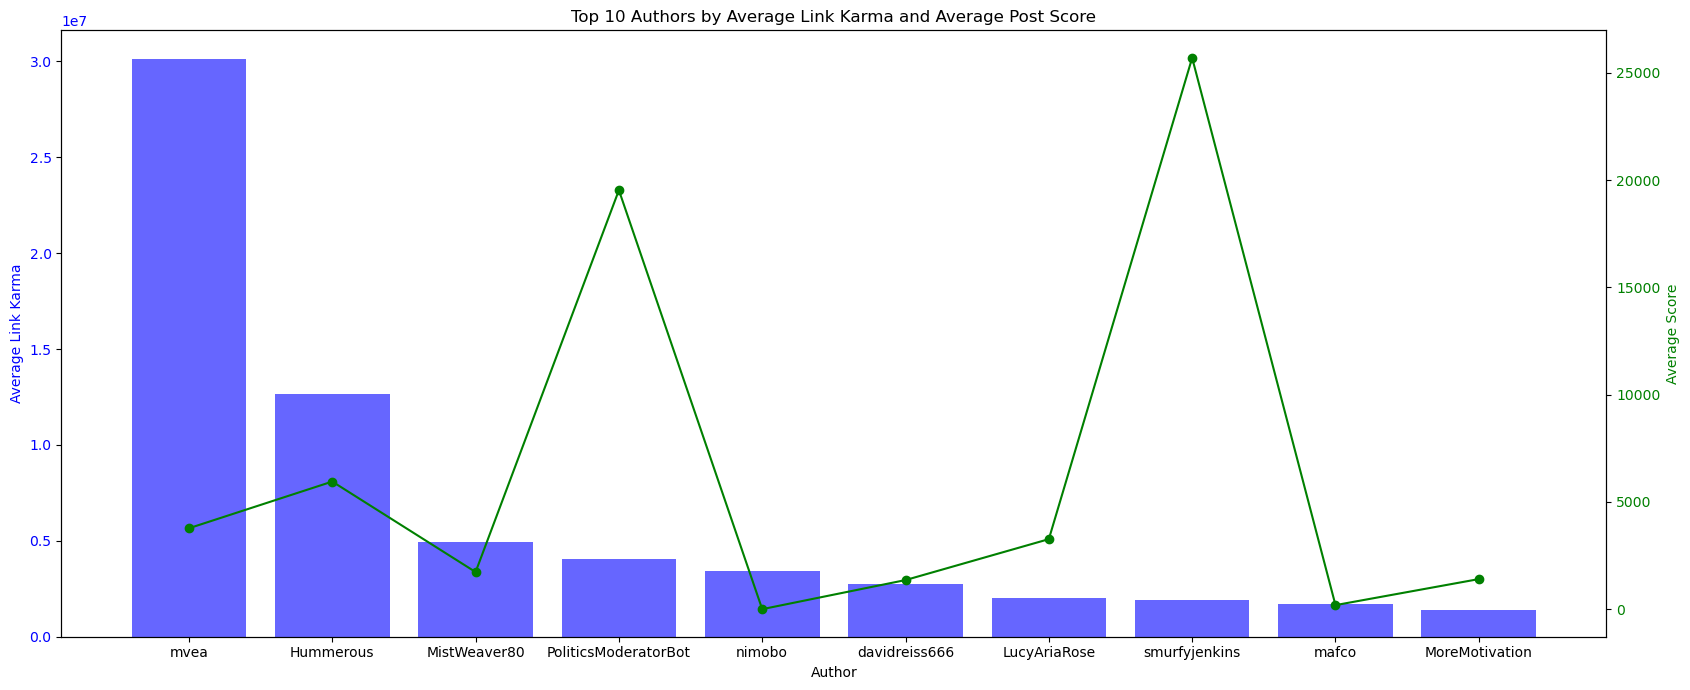

In [49]:
author_stats = df_posts.groupby('Author').agg(
    avg_link_karma=('Link Karma', 'mean'),  # Average link karma by each author
    avg_score=('Score', 'mean')             # Average score of posts by the author
).reset_index()

top_10_authors = author_stats.sort_values(by='avg_link_karma', ascending=False).head(10)

# Step 3: Create a figure and axis for the dual-axis plot
fig, ax1 = plt.subplots(figsize=(17,7))

# Plot the average link karma as bars on the first y-axis
ax1.set_xlabel('Author')
ax1.set_ylabel('Average Link Karma', color='blue')
ax1.bar(top_10_authors['Author'], top_10_authors['avg_link_karma'], color='blue', alpha=0.6)
ax1.tick_params(axis='y', labelcolor='blue')

# Step 4: Create a second y-axis for the average post score
ax2 = ax1.twinx()
ax2.set_ylabel('Average Score', color='green')
ax2.plot(top_10_authors['Author'], top_10_authors['avg_score'], color='green', marker='o')
ax2.tick_params(axis='y', labelcolor='green')

# Step 5: Add a title and show the plot
plt.title('Top 10 Authors by Average Link Karma and Average Post Score')
plt.xticks(rotation=180)
plt.tight_layout()
plt.show()

In [50]:
mv_posts = df_posts[df_posts['Author'].str.lower() == 'mvea']

mv_posts

Post Title Author  Score  \
5   Fracking is one of the least sustainable ways ...   mvea   5684   
17  Internet companies too big? FTC chair says mor...   mvea   1861   

    Comments Count Post ID                                           Post URL  \
5              275  7qrvka  http://www.independent.co.uk/environment/frack...   
17             141  6zty0s  https://www.usatoday.com/story/tech/2017/09/12...   

          Created Date   Subreddit Post Text  Subscribers  Link Karma  \
5  2018-01-16 13:04:45     science       N/A     33031268    30116307   
17 2017-09-13 13:32:04  Futurology       N/A     20944084    30116307   

    Comment Karma Cleaned Post Text  \
5          405026                 n   
17         405026                 n   

                                     Sentiment Scores  Compound Sentiment  \
5   {'neg': 0.0, 'neu': 0.0, 'pos': 0.0, 'compound...       0.0   neutral   
17  {'neg': 0.0, 'neu': 0.0, 'pos': 0.0, 'compound...       0.0   neutral   

    Log Score  
5    8.645586  
17   7.529406

In [51]:
smurfy_posts = df_posts[df_posts['Author'].str.lower() == 'smurfyjenkins']

smurfy_posts

Post Title         Author  Score  \
76  During the Reconstruction-era, the election of...  smurfyjenkins  25691   

    Comments Count Post ID                                           Post URL  \
76             624  gvhui4  https://www.cambridge.org/core/journals/journa...   

          Created Date Subreddit Post Text  Subscribers  Link Karma  \
76 2020-06-03 00:51:59   science       N/A     33031273     1921691   

    Comment Karma Cleaned Post Text  \
76          59354                 n   

                                     Sentiment Scores  Compound Sentiment  \
76  {'neg': 0.0, 'neu': 0.0, 'pos': 0.0, 'compound...       0.0   neutral   

    Log Score  
76  10.153935

In [52]:
author_post_count = df_posts.groupby('Author').size().reset_index(name='Num_Posts')

author_avg_score = df_posts.groupby('Author')['Score'].mean().reset_index(name='Avg_Score')

author_stats = pd.merge(author_post_count, author_avg_score, on='Author')

n = len(author_stats)

pearson_corr, pearson_p_value = stats.pearsonr(author_stats['Num_Posts'], author_stats['Avg_Score'])

t_stat_pearson = pearson_corr * np.sqrt((n - 2) / (1 - pearson_corr**2))
p_value_ttest_pearson = stats.t.sf(np.abs(t_stat_pearson), df=n-2) * 2  # two-tailed test

print(f"Pearson's Correlation: {pearson_corr:.4f}, p-value: {pearson_p_value:.4f}")
print(f"Pearson's Correlation t-statistic: {t_stat_pearson:.4f}, p-value: {p_value_ttest_pearson:.4f}")

alpha = 0.05  # significance level
if p_value_ttest_pearson < alpha:
    print(f"The Pearson correlation is significant (p < {alpha})")
else:
    print(f"The Pearson correlation is not significant (p ≥ {alpha})")

Pearson's Correlation: 0.0395, p-value: 0.5834
Pearson's Correlation t-statistic: 0.5493, p-value: 0.5834
The Pearson correlation is not significant (p ≥ 0.05)


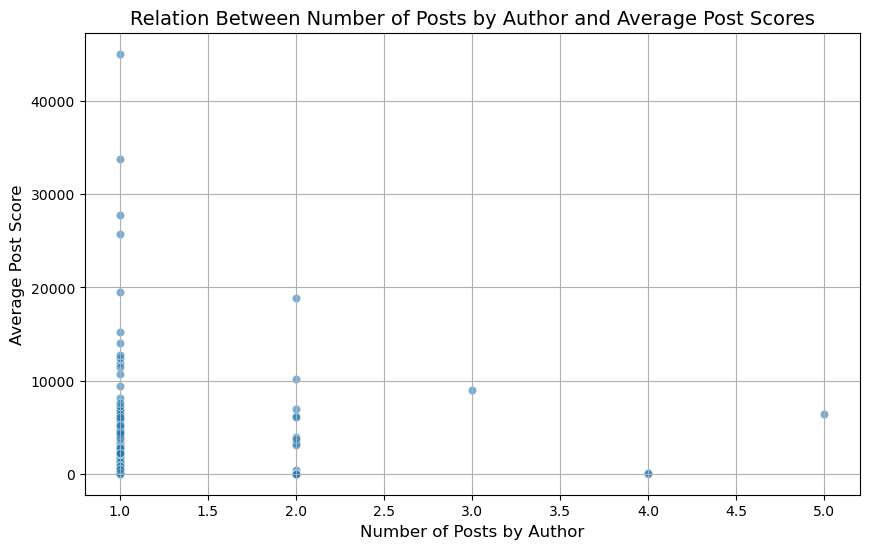

In [53]:
author_post_counts = df_posts.groupby('Author').size().reset_index(name='Num Posts')

author_avg_scores = df_posts.groupby('Author')['Score'].mean().reset_index(name='Avg_Score')

author_stats = pd.merge(author_post_counts, author_avg_scores, on='Author')

plt.figure(figsize=(10, 6))

sns.scatterplot(x='Num Posts', y='Avg_Score', data=author_stats, alpha=0.6)
plt.title('Relation Between Number of Posts by Author and Average Post Scores', fontsize=14)
plt.xlabel('Number of Posts by Author', fontsize=12)
plt.ylabel('Average Post Score', fontsize=12)
plt.grid(True)

plt.show()

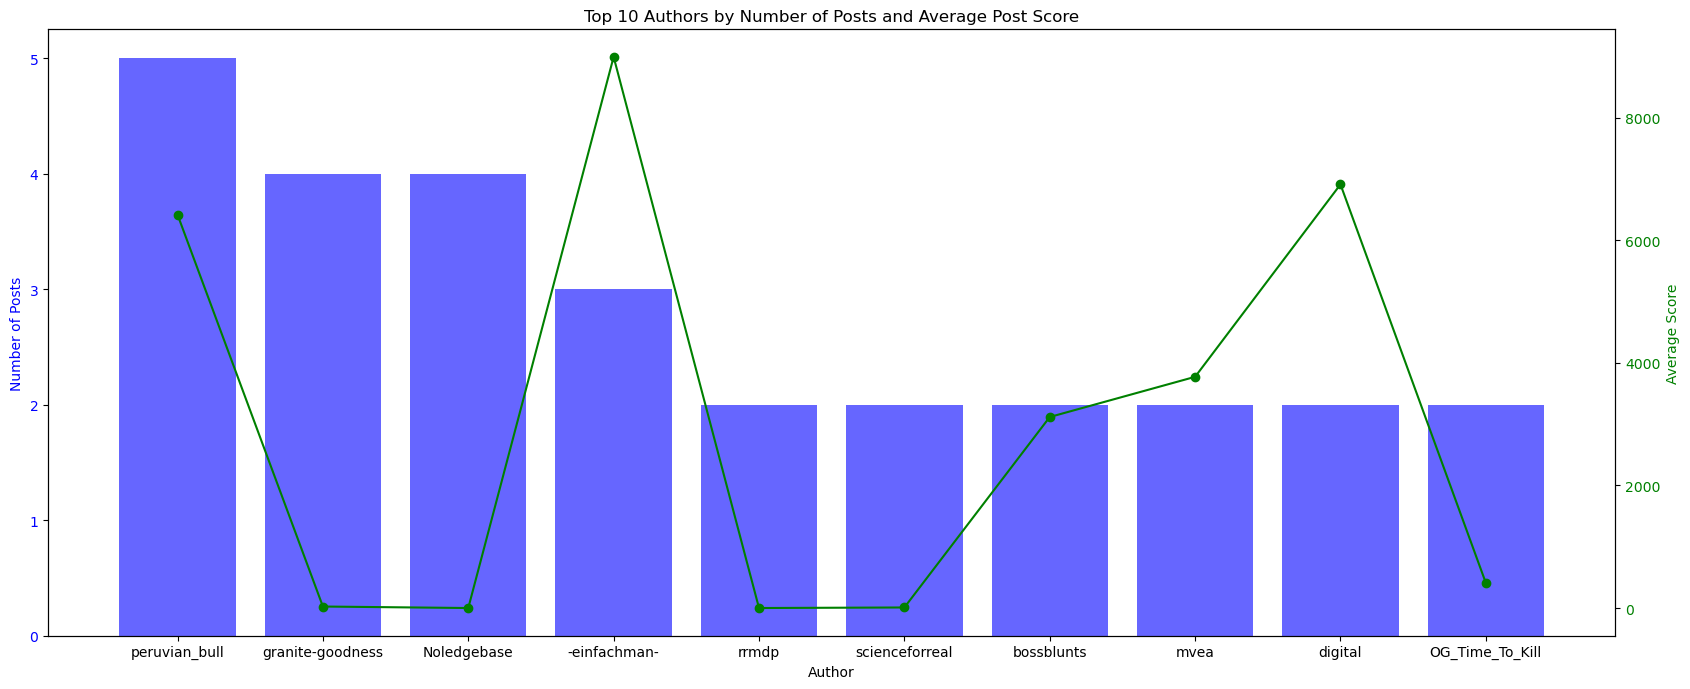

In [54]:
author_stats = df_posts.groupby('Author').agg(
    num_posts=('Post ID', 'count'),  # Number of posts by each author
    avg_score=('Score', 'mean')      # Average score of posts by the author
).reset_index()

top_10_authors = author_stats.sort_values(by='num_posts', ascending=False).head(10)

fig, ax1 = plt.subplots(figsize=(17,7))

ax1.set_xlabel('Author')
ax1.set_ylabel('Number of Posts', color='blue')
ax1.bar(top_10_authors['Author'], top_10_authors['num_posts'], color='blue', alpha=0.6)
ax1.tick_params(axis='y', labelcolor='blue')

ax2 = ax1.twinx()
ax2.set_ylabel('Average Score', color='green')
ax2.plot(top_10_authors['Author'], top_10_authors['avg_score'], color='green', marker='o')
ax2.tick_params(axis='y', labelcolor='green')

plt.title('Top 10 Authors by Number of Posts and Average Post Score')
plt.xticks(rotation=180)
plt.tight_layout()
plt.show()

In [55]:
noledge_posts = df_posts[df_posts['Author'].str.lower() == 'noledgebase']

noledge_posts

Post Title       Author  Score  \
172  Environmental Economics: Sustainable Growth fo...  Noledgebase      1   
214  Environmental Economics: Sustainable Growth fo...  Noledgebase      1   
222  Environmental Economics: Sustainable Growth fo...  Noledgebase      1   
224  Environmental Economics: Sustainable Growth fo...  Noledgebase      1   

     Comments Count  Post ID  \
172               0  1fzjps8   
214               0  1fjz1i4   
222               0  1fgegfx   
224               0  1fe141d   

                                              Post URL        Created Date  \
172  https://www.jucktion.com/f/udemy-coupon/enviro... 2024-10-09 06:50:57   
214  https://www.jucktion.com/f/udemy-coupon/enviro... 2024-09-18 19:51:08   
222  https://www.jucktion.com/f/udemy-coupon/enviro... 2024-09-14 06:50:47   
224  https://www.jucktion.com/f/udemy-coupon/enviro... 2024-09-11 05:51:05   

    Subreddit Post Text  Subscribers  Link Karma  Comment Karma  \
172   Udemies       N/A         1909        1440            613   
214   Udemies       N/A         1909        1440            613   
222   Udemies       N/A         1909        1440            613   
224   Udemies       N/A         1909        1440            613   

    Cleaned Post Text                                   Sentiment Scores  \
172                 n  {'neg': 0.0, 'neu': 0.0, 'pos': 0.0, 'compound...   
214                 n  {'neg': 0.0, 'neu': 0.0, 'pos': 0.0, 'compound...   
222                 n  {'neg': 0.0, 'neu': 0.0, 'pos': 0.0, 'compound...   
224                 n  {'neg': 0.0, 'neu': 0.0, 'pos': 0.0, 'compound...   

     Compound Sentiment  Log Score  
172       0.0   neutral   0.693147  
214       0.0   neutral   0.693147  
222       0.0   neutral   0.693147  
224       0.0   neutral   0.693147

In [56]:
top_10_authors

Author  num_posts    avg_score
166     peruvian_bull          5  6418.000000
139  granite-goodness          4    25.500000
66        Noledgebase          4     1.000000
0        -einfachman-          3  8991.333333
173             rrmdp          2     1.000000
175    scienceforreal          2    10.000000
119        bossblunts          2  3117.000000
159              mvea          2  3772.500000
130           digital          2  6911.500000
67    OG_Time_To_Kill          2   410.000000

In [57]:
full_title = df_posts.loc[df_posts['Author'] == '-einfachman-', 'Post Title'].values[0]
print(full_title)

Burning Cash Part III


In [58]:
df_posts.loc[df_posts['Author'] == '-einfachman-', 'Post Text'].values[0][:1000]

"**TL;DR: Citadel has a bargaining chip to keep the GME price at bay—the threat of a market crash if GME were to MOASS. This bargaining chip, however, is only valid until the market actually crashes. And based on several indicators, the market has a few years left max before it collapses and massive liquidations begin.**\n\n\\------------------------------------------------------------------------------------------------------------------------------------------------\n\nRecommended Prerequisite DD:\n\n1. [Burning Cash Part II](https://www.reddit.com/r/Superstonk/comments/16ryoqa/burning_cash_part_ii/)\n\n\\------------------------------------------------------------------------------------------------------------------------------------------------\n\n[Burning Cash Part III](https://imgur.com/a/xnCW5hZ)\n\n§1: Citadel's Bargaining Chip\n\n§2: The Inevitable Market Crash\n\n\\---------------------------------------------------------------------------------------------------------------

In [59]:
df_posts.to_csv('EnSu.csv', index=False)